In [545]:
import mne
import mne_nirs
import numpy as np
import matplotlib.pyplot as plt
import random

import pywt
import math

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable

import os
import pandas as pd
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.linear_model import LinearRegression
from scipy.special import gamma
from scipy.optimize import curve_fit
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX



from mne_nirs.experimental_design import make_first_level_design_matrix
from mne_nirs.statistics import run_glm
from mne_nirs.channels import (get_long_channels,
                               get_short_channels,
                               picks_pair_to_idx)

from nilearn.plotting import plot_design_matrix


In [111]:
time_win = 30
sc_factor = 1
sample_rate = 8.93
signal_rate = 8.93
signal_length = time_win * signal_rate
norm_base = 16
print(signal_length)

resting_state_path = "/Users/kostasdemiris/Downloads/snirf/"

'''
Blanco B, Molnar M, Carreiras M, Caballero-Gaudes C. 
Open access dataset of task-free hemodynamic activity in 4-month-old infants during sleep using fNIRS. 
Sci Data. 2022 Mar 25;9(1):102. doi: 10.1038/s41597-022-01210-y. PMID: 35338168; PMCID: PMC8956728.'''


267.9


'\nBlanco B, Molnar M, Carreiras M, Caballero-Gaudes C. \nOpen access dataset of task-free hemodynamic activity in 4-month-old infants during sleep using fNIRS. \nSci Data. 2022 Mar 25;9(1):102. doi: 10.1038/s41597-022-01210-y. PMID: 35338168; PMCID: PMC8956728.'

In [3]:
# This is the base MNE dataset
fnirs_folder = mne.datasets.fnirs_motor.data_path()
fnirs_cw_amplitude_dir = fnirs_folder / "Participant-1"
raw_intensity = mne.io.read_raw_nirx(fnirs_cw_amplitude_dir, verbose=True)
raw_intensity.load_data()



raw_intensity.annotations.set_durations(time_win)
raw_intensity.annotations.rename(
    {"1.0": "Control", "2.0": "Tapping/Left", "3.0": "Tapping/Right"}
)
unwanted = np.nonzero(raw_intensity.annotations.description == "15.0")
raw_intensity.annotations.delete(unwanted)
# Apparently channel 15 is unrelated to the motor activation experiment,
# it was used to signal something unrelated and so will be ignored

# Removes short channels
picks = mne.pick_types(raw_intensity.info, meg = False, fnirs = True)
dists = mne.preprocessing.nirs.source_detector_distances(
    raw_intensity.info, picks = picks)
raw_intensity.pick(picks[dists > 0.01])



# Converting to optical density based on readings, then to haemo readings
raw_od = mne.preprocessing.nirs.optical_density(raw_intensity)
raw_haemo = mne.preprocessing.nirs.beer_lambert_law(raw_od, ppf=6)

# We filter them to remove the frequencies associated with cardiac activity (unrelated)
raw_haemo_unfiltered = raw_haemo.copy()
# raw_haemo.filter(0.05, 0.7, h_trans_bandwidth = 0.2, l_trans_bandwidth = 0.02)



# Creates epochs for each occurence of an event (Left tap, right tap, control)
reject_criteria = dict(hbo=80e-6)
tmin, tmax = -1, time_win-1
events, event_dict = mne.events_from_annotations(raw_haemo)


epochs = mne.Epochs(
    raw_haemo,
    events,
    event_id=event_dict,
    tmin=tmin,
    tmax=tmax,
    reject=reject_criteria,
    reject_by_annotation=True,
    proj=True,
    baseline=(None, 0),
    preload=True,
    detrend=None,
    verbose=True,
)

isolated_event_epochs = epochs["Tapping"]
control_event_set = epochs["Control"]
isol_dhrf_data = isolated_event_epochs.get_data(copy=True)
isol_cont_data = control_event_set.get_data(copy=True)
avg_haemo_func_tapping = isolated_event_epochs.average()
std_dev = np.std(avg_haemo_func_tapping.data, axis=0)

Loading /Users/kostasdemiris/mne_data/MNE-fNIRS-motor-data/Participant-1
Reading 0 ... 23238  =      0.000 ...  2974.464 secs...
Used Annotations descriptions: ['Control', 'Tapping/Left', 'Tapping/Right']
Not setting metadata
90 matching events found
Setting baseline interval to [-1.024, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 90 events and 236 original time points ...
0 bad epochs dropped


In [488]:
sfreq = 7.81
amp = 3

raw = mne_nirs.simulation.simulate_nirs_raw(
    sfreq=sfreq, sig_dur=60 * 5, amplitude=amp, isi_min=30., isi_max=60.)

print(np.shape(raw.get_data()))
experimental_overlay = isol_cont_data.copy()
associated_hrfs = []
print(np.shape(experimental_overlay))
index = 0
while index < len(experimental_overlay):
    hrf_tape = mne_nirs.simulation.simulate_nirs_raw(
        sfreq=sfreq, sig_dur=60 * 5, amplitude=amp, isi_min=30., isi_max=60.)
    hrf_data = hrf_tape.get_data()[0]
    generated_hrf, event_id = mne.events_from_annotations(hrf_tape)
    for starting_point in generated_hrf:
        if index < len(experimental_overlay) and starting_point[0] + signal_length < len(hrf_data):
            experimental_overlay[index][0] += hrf_data[starting_point[0]: starting_point[0] + len(experimental_overlay[index][0])]
            associated_hrfs.append(hrf_data[starting_point[0]: starting_point[0] + len(experimental_overlay[index][0])])
            index += 1
print(len(experimental_overlay), "done")


(1, 2343)
(30, 40, 236)
Used Annotations descriptions: ['A']
Used Annotations descriptions: ['A']
Used Annotations descriptions: ['A']
Used Annotations descriptions: ['A']
Used Annotations descriptions: ['A']
Used Annotations descriptions: ['A']
30 done


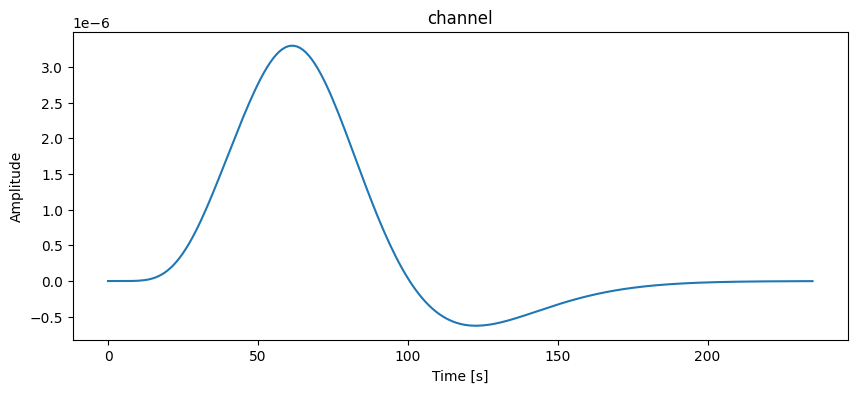

<Figure size 640x480 with 0 Axes>

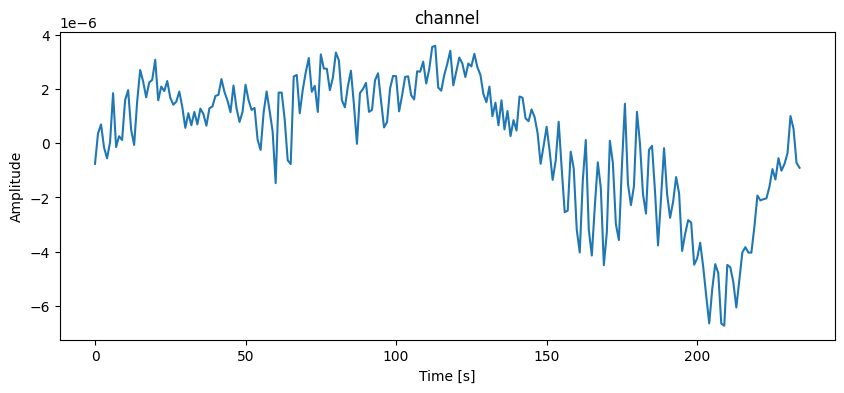

<Figure size 640x480 with 0 Axes>

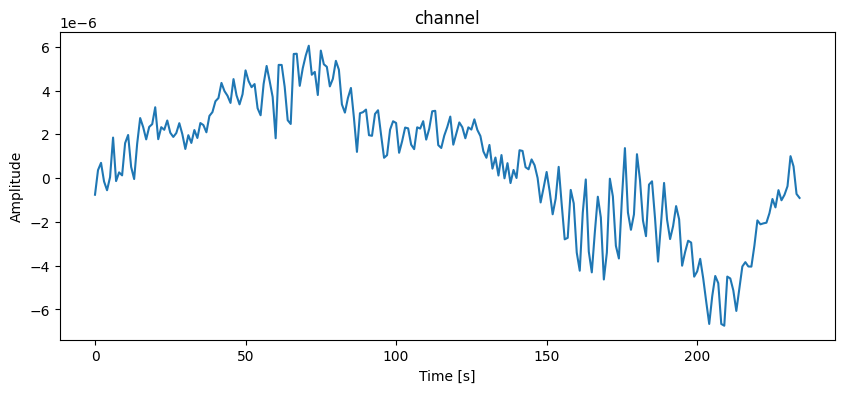

<Figure size 640x480 with 0 Axes>

In [489]:
displays.plot_pChannel(associated_hrfs[0], range(len(associated_hrfs[0])))
displays.plot_pChannel(overlay[0], range(len(overlay[0])))
displays.plot_pChannel(associated_hrfs[0][:235] + overlay[0][:235], range(len(associated_hrfs[0][:235])))


In [549]:
class display:
    def __init__(self, time_sig):
        self.time_signal = time_sig
    
    def display_gray_arr(self, img_arr):
        plt.imshow(img_arr, cmap='gray')
        plt.title("Wavelet As Image")
        plt.axis('off')
        plt.show()
    
    def plot_pChannel(self, points, time_series):
        plt.figure(figsize=(10, 4))
        plt.plot(time_series, points)
        plt.title("channel")
        plt.xlabel("Time [s]")
        plt.ylabel("Amplitude")
        plt.show()
        plt.clf()
        
    def plot_multiChannel(self, channel_arr, time_series):
        fig, ax = plt.subplots()
        for i, array in enumerate(channel_arr):
            ax.plot(time_series, channel_arr[i], label="Channel {i+1}")
        ax.set_xlabel('Time: in seconds')
        ax.set_ylabel('Amplitude ')
        ax.set_title('Multiple Channels plotted on one image')
    
    def plot_scatter_data(self, data_points, central=0.5):
        # Useful for power spectra, not currently used but could be
        plt.scatter([i for i in range(len(data_points))], data_points, color='white', alpha=0.5)

        for i in range(len(data_points)):
            plt.plot([i, i], [data_points[i], central], color='red', alpha=0.5)

        plt.axhline(y=central, color='green', linestyle='--')

        plt.title('Scatter plot')
        plt.xlabel('Index')
        plt.ylabel('Value')
        plt.grid(True)
        plt.show()
        
    def plot_comparision_data(self, original_data, reconstructed_data, time_signal):
        plt.figure(figsize=(10, 6))
        plt.plot(time_signal, original_data, label='Original')
        plt.plot(time_signal, reconstructed_data, label='Reconstructed')
        plt.title('Comparision')
        plt.xlabel('Time')
        plt.ylabel('Amplitude')
        plt.legend()
        plt.grid(True)
        plt.show()
        plt.clf()
        
    def plot_wavedec_spect(self, coeffs):
        coefficients_array = []
        max_length = max(len(i) for i in coeffs)
        
        for level, row in enumerate(coeffs):
            stretched_row = np.repeat(row, np.ceil(max_length / len(row)).astype(int))
            coefficients_array.append(stretched_row[:max_length]) # Again, this is just for display, not actually used
            
            
        coeffs_matrix = np.vstack(coefficients_array)
        norm_coeff_matrix = np.repeat(normalise(coeffs_matrix), 3, axis=0)
        
        print(f"shape is {np.shape(norm_coeff_matrix)}")
        plt.clf()
        plt.figure(figsize=(10, 5))
        plt.imshow(norm_coeff_matrix, cmap='brg')
        plt.colorbar(label='Magnitude')
        plt.ylabel('Depth')
        plt.xlabel('Time')
        plt.title('WAVEDEC DISPLAY SPECTOGRAM')
        plt.show()
        
    def plot_wavedec_layer(self, coeffs, start_time=-1, stop_time=time_win-1):
        for depth, row in enumerate(coeffs):
            plt.figure(figsize=(10, 4))
            time_row = np.linspace(start_time, stop_time, num=len(row))
            plt.plot(time_row, row)
            plt.title(f"wavelet level {depth + 1}")
            plt.xlabel("Time")
            plt.ylabel("Amplitude")
            plt.show()
            
    def plot_comp_wavedec_layer(self, coeffs, recoefs, start_time=-1, stop_time=time_win-1):
        for depth, row in enumerate(coeffs):
            plt.figure(figsize=(10, 4))
            time_row = np.linspace(start_time, stop_time, num=len(row))
            plt.plot(time_row, row, label='Original')
            plt.plot(time_row, recoefs[depth], label='Reconstructed')
            plt.title(f"wavelet level {depth + 1}")
            plt.xlabel("Time")
            plt.ylabel("Amplitude")
            plt.legend()
            plt.show()

class Normalisations:
    def __init__(self):
        self.log_mag_reduction = np.vectorize(lambda t: np.sign(t) * (np.log1p(np.absolute(t))))
        # Direction (+1 or -1) multiplied by reduced magnitude representation. reduces mag but doesn't change dir.
        self.exp_mag_increase = np.vectorize(lambda t: np.sign(t) * (np.expm1(np.absolute(t))))
        # Reverses logarithmic magnitude reduction function
        
    def z_normalisation(self, data, d_mean, d_std):
        return (data - d_mean) / d_std
    
    def inv_z_normalisation(self, data, d_mean, d_std):
        return (data * d_std) + d_mean
    
    def per_band_wavelet_normalisation(self, padded_set_wavs, param_set = None):
        # padded_wavelet
        # Param set lets us use another dataset's standard deviation and mean to normalise our current one,
        # letting us compare them without having to un-normalise them. Necessary in some later code.
        
        # this does NOT do logarithmic magnitude reduction by default, that is done within the padded_set
        if param_set is None:
            param_set = padded_set_wavs
            
        band_means = [np.mean(
            param_set[:, i][param_set[:, i] != 0])
                      for i in range(len(param_set[0]))
        ]
        band_stds = [np.std(
            param_set[:, i][param_set[:, i] != 0])
                      for i in range(len(param_set[0]))
        ]
    
        for band in range(len(padded_set_wavs[0])):
            padded_set_wavs[:, band][padded_set_wavs[:, band] != 0] = (
                (padded_set_wavs[:, band][padded_set_wavs[:, band] != 0]
                     - band_means[band]) / band_stds[band]
            )
        
        return padded_set_wavs  
    
    def inv_per_band_wavelet_normalisation(self, data_set, band_means, band_stds, magnitude_correction=None, expon = True):        
        if magnitude_correction is None:
            magnitude_correction = 0
            
        data_set = np.array(data_set)
        for band in range(len(data_set[0])):
            data_set[:, band][data_set[:, band] != 0] = (
                (data_set[:, band][data_set[:, band] != 0]
                 * band_stds[band]) + band_means[band]
            )
        
        if expon:
            # Again for letting us control the process, lets us not apply the exponential if we have disabled part
            # of the normalisation
            data_set = self.exponential_magnitude_increase(data_set, magnitude_correction)
        
        return data_set
    
    
    def get_min_order_of_magnitude(self, array):
        flattened_array = np.array(array).flatten()
        smallest_mag_val = np.min(np.abs(flattened_array[flattened_array != 0]))
        min_magnitude = np.floor(np.log10(smallest_mag_val))
        return min_magnitude
        
    def logarithmic_magnitude_reduction(self, dataset, magnitude_correction=None):
        # Unlike name, doesn't actually reduce magnitude, it just converts everything into a representation with
        # logged numbers with magnitudes greater than 1e+0 at minimum
        if magnitude_correction is None:
            print("mag was calculated")
            magnitude_correction = self.get_min_order_of_magnitude(dataset)
        increased_mag_dataset = dataset * (10 ** max(- magnitude_correction, 0)) # Magnitude correction always neg.
        logged_dataset = np.sign(dataset) * np.log1p(np.absolute(increased_mag_dataset))
        # log1p so that the padded zeros stay as zeros.
        return logged_dataset
    
    def exponential_magnitude_increase(self, dataset, magnitude_correction):
        # It's necessary to manually input magnitude correction, because it can't be found from the dataset,
        # and so a log_mag_red without a mag_correction is not inversed by a exp_mag_inc without a mag_correction
        
        # The inverse of logarithmic magnitude reduction
        delogged_dataset = np.sign(dataset) * np.expm1(np.absolute(dataset))
        decreased_mag_dataset = (10 ** min(magnitude_correction, 0)) * delogged_dataset

        return decreased_mag_dataset
    
    def bandpass_filter(signal, lower_threshold, upper_threshold, sample_freq = sfreq):
        pass
    
class Conversions:
    def __init__(self):
        pass
    
    def cwt(self, complex_signal, wavelet='cmor', sample_rate=sample_rate):
        # Using this cmor wavelet for the cwt, it's the complex morlet wavelet 
        scales = np.arange(1, 129)  
        coefficients, frequencies = pywt.cwt(complex_signal, scales, wavelet, sampling_period=1/sample_rate)
        return coefficients, frequencies
    
    def dwt(self, data, wavelet='db4'):
        # db4 is chosen as the default basis function because it looks like the canonical hrf (kinda).
        coefficients, frequencies = pywt.dwt(data, wavelet)
        return coefficients, frequencies
    
    def wavedec(self, data, wavelet='sym4'):
        max_depth = pywt.dwt_max_level(len(data), wavelet)
        coeffiecients = pywt.wavedec(data, wavelet, level=max_depth)
        return coeffiecients
    
    def waverec(self, coefficients, wavelet='sym4'):
        recovered = pywt.waverec(coefficients, wavelet)
        return recovered
    
    def inv_dwt(self, coeffs, freqs, wavelet='sym4'):
        return pywt.idwt(coeffs, freqs, wavelet)

class Evaluations:
    def __init__(self):
        pass
    
    def root_signal_power(self, signal):
        square_sum = np.sum(np.power(signal, 2)) 
        root_mean = (square_sum / len(signal)) ** 0.5
        return root_mean
        
    def signal_to_noise_ratio(self, signal, noise):
        # Not exactly signal to noise. I'm using root of signal power because it was better for my purposes i guess
        signal_power = self.root_signal_power(signal)
        noise_power = self.root_signal_power(noise)
        return signal_power / signal_noise
    
    def contrast_to_noise(self, signal, noise):
        signal_power = self.root_signal_power(signal)
        noise_power = self.root_signal_power(noise)
        std_noise = np.std(noise)
        return np.abs(signal_power - noise_power) / std_noise
    
    def root_mean_square_error(self, recon_signal, target_signal):
        mean_error = np.mean((target_signal - recon_signal) ** 2)
        return (mean_error ** 0.5)
    
    def peak_signal_to_noise_ratio(self, signal, desired_signal, max_i = 1):
        # Maximum possible intensity (max_i) is assumed to be 1 due to min-max normalisation, but can be changed
        return (20 * np.log(10, max_i)) - (10 * np.log(10, self.root_mean_square_error(signal, desired_signal))) 
    
class Generations:
    def __init__(self):
        self.autoreg_model = None
        self.order = 0
    
    def gen_hrf_set(self, hrf_num, sample_length = np.ceil(signal_length).astype(int)):
        hrf_set = np.zeros((hrf_num, sample_length))
        index = 0

        while index < hrf_num:
            print(f"Index is currently {index}")
            hrf_tape = mne_nirs.simulation.simulate_nirs_raw(
                    sfreq=sfreq, sig_dur=60 * 50, amplitude=amp, isi_min=30., isi_max=60., stim_dur=random.uniform(3., 6.))
            
            hrf_data = hrf_tape.get_data()[0]
            generated_hrf, event_id = mne.events_from_annotations(hrf_tape)

            for start in generated_hrf:
                if index < hrf_num and start[0] + sample_length + 1 < len(hrf_data):
                    hrf_set[index] = (hrf_data[start[0]: start[0] + sample_length])
                index += 1

        extract_data = np.zeros((hrf_num, sample_length))
        for i in range(len(extract_data)):
            shift_index = random.randint(0, (len(hrf_set[i]))//8)
            extract_data[i] = np.concatenate((np.full(shift_index, 1e-15), (hrf_set[i] * np.random.uniform(low=0.6, high=1.4))[:sample_length-shift_index]))
            
        return extract_data
    
    def gen_frequency(self, frequency, amplitude, sample_rate, point_number, starting_offset=0):
        f_timeseries, step_interval = [], 1 / (sample_rate * frequency)
        for time in range(point_number):
            f_timeseries.append(amplitude * math.sin(time * step_interval))
        return np.array(f_timeseries)
    
    def gen_vari_frequency(self, frequency, f_variability, amplitude, a_variability, sample_rate, point_number, starting_offset=0):
        f_timeseries, step_interval = [], 1 / (sample_rate * frequency)
        target_frequency = np.random.uniform(frequency-f_variability, frequency+f_variability)
        target_amplitude = np.random.uniform(amplitude-a_variability, amplitude+a_variability)
        for time in range(point_number):
            if time % 100 == 0:
                target_frequency = np.random.uniform(frequency-f_variability, frequency+f_variability)
                target_amplitude = np.random.uniform(amplitude-a_variability, amplitude+a_variability)
                target_frequency = max(target_frequency, 1e-6)
                target_amplitude = max(target_amplitude, 1e-10)
                # Just very low terms to prevent it being zero
            frequency += 0.1 * np.log(target_frequency) - np.log(frequency)
            amplitude += 0.01 * amplitude * (np.log(target_amplitude) - np.log(amplitude))
            step_interval =1 / (sample_rate * frequency)
            value = (amplitude * math.sin(time * step_interval * frequency))
            if np.isnan(value):
                print(f"amp {amplitude}, targ amp {target_amplitude}, freq {frequency}, time {time}, step_int {step_interval}")

            f_timeseries.append(value)
        return np.array(f_timeseries)
    
    def gen_motion_artifact(self, signal_length, sample_rate = sample_rate, peak_amp_range=(0.25e-6, 1e-6), time_to_peak = 7.0, random_scale = (0.5, 1.5)):
        peak_amp_range = np.random.uniform(peak_amp_range[0], peak_amp_range[1])
        random_scale = np.random.uniform(random_scale[0], random_scale[1])
        time_to_peak = time_to_peak + (random.uniform(-50, 50) * (1/sample_rate))
        
        motion_artifact = np.array([(peak_amp_range * np.exp(- np.absolute((t / sample_rate) - time_to_peak) / random_scale)) for t in range(signal_length)])
        return motion_artifact
    
    def gen_baseline_shifts(self, signal_length, shift_number, sample_rate = sample_rate, time_to_shift = 10, magnitude_scaler = 1):
        # These are for motion artefacts' baseline shifts.
        pass
    
    
    def init_autoreg_model(self, order):
        self.autoreg_model = Auto_Regressive_Model(order)
        self.order = order
        
        training_data = self.gen_white_noise(order * 100) 
        # Arbitrary number for training purposes
        
        self.autoreg_model.fit(training_data)
        
        
    # -------------------- Gamma function HRF section ------------------
    
    @staticmethod
    def gamma_distribution(times, k, theta):
        distribution = np.array(
            [(t ** (k-1)) * (math.exp(-t / theta)) / (gamma(k) * (theta** k)) for i in times]
        )
        return distribution
    
    @staticmethod
    def simulate_hrf(times, k1, k2, theta1, theta2):
        # Has to be a static method for us to pass it into the linear regression model, 
        # this is not to be used in actual generation, it's just for getting the right parameters
        sim_hrf = (Generation.gamma_distribution(times, k1, theta1) - 
                    Generation.gamma_distribution(times, k2, theta2))
        
        return sim_hrf
    
    def get_hrf_parameters(self, canonical_hrf):
        pass
        #comebackto
    

    
    # -------------- Individual Component Generation Section -----------
    
    # Numbers are from the method of: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC10295283/ 
    
    def gen_white_noise(self, point_num):
        return np.random.random_sample(size=(point_num,)) - 0.5

    def gen_autoReg_noise(self, point_num, order=6, mc_depth = 3, iter_avg = True):        
        if (self.autoreg_model is None) or (self.order != order):
            self.init_autoreg_model(order)
        
        baseline_noise = self.gen_white_noise(order * 5)
        return self.autoreg_model.predict(baseline_noise, point_num, mc_depth, iterative_averaging = iter_avg)
    
    def gen_nirs_data(self, sample_rate, signal_length, amplitude, min_nirs_interval=15.0, max_nirs_interval=45.0):
        return mne_nirs.simulation.simulate_nirs_raw(sfreq=sample_rate, sig_dur=signal_length, amplitude=amplitude, isi_min=min_nirs_interval, isi_max=max_nirs_interval)
    
    def gen_heart_signal(self, sample_rate, point_num, frequency=1., fvar=0.1, amplitude=2e-7, avar=1e-7):
        #heart_sig = self.gen_frequency(frequency, amplitude, sample_rate, point_num, random.randint(0, 100))
        heart_sig = self.gen_vari_frequency(frequency, fvar, amplitude, avar, sample_rate, point_num, starting_offset=random.randint(0, 100))
        return heart_sig
    
    def gen_mayer_signal(self, sample_rate, point_num, frequency=0.1, fvar=0.01, amplitude=2e-7, avar=1e-7):
        mayer_sig = self.gen_frequency(frequency, amplitude, sample_rate, point_num, random.randint(0, 100))
        return mayer_sig
    
    def gen_respi_signal(self, sample_rate, point_num, frequency=0.25, fvar=0.01, amplitude=2e-7, avar=1e-7):
        respi_sig = self.gen_vari_frequency(frequency, fvar, amplitude, avar, sample_rate, point_num, starting_offset=random.randint(0, 100))
        return respi_sig
    
    def gen_vlow_freq_signal(self, sample_rate, point_num, frequency=0.01, amplitude=2e-7):
        # This is just to take into account the very low frequency components of the signal that cause trends in the data
        low_freq_sig = self.gen_frequency(frequency, amplitude, sample_rate, point_num, random.randint(0, 10))
        return low_freq_sig
    
    def gen_resting_state_data(self, sample_rate, point_num):
        heart_signal = self.gen_heart_signal(sample_rate, point_num)
        mayer_signal = self.gen_mayer_signal(sample_rate, point_num)
        respi_signal = self.gen_respi_signal(sample_rate, point_num)
        lFreq_signal = self.gen_vlow_freq_signal(sample_rate, point_num)

        return heart_signal + mayer_signal + respi_signal + lFreq_signal

    def gen_overlay_data(self, sample_number, sample_length, r_magnitude= 2e-7):
        overlay_data = np.array([
            generator.gen_resting_state_data(sample_rate, sample_length)
            + (generator.gen_autoReg_noise(sample_length) * r_magnitude)
            for data_point in range(sample_number)
        ])
        return overlay_data
    
    def generate_basic_test_data(self, data_length, sample_length=np.ceil(signal_length).astype(int)):
        overlay_data = self.gen_overlay_data(data_length, sample_length)
        extract_data = self.gen_hrf_set(data_length, sample_length= sample_length)
        
        return extract_data, overlay_data
    
    def generate_tape_test_data(self, data_length, sample_length):
        # Unknown when an hrf is or not, it's just two distinct tapes. Good for testing
        overlay_tape = self.gen_overlay_data(1, (data_length + 1))[0]
        motion_artifacts = None
        extract_tape = None # comebackto
        
    
    # ---------------------- End of Individual Component Section -------------------

    
# Data Generation models
class Auto_Regressive_Model():
    # Uses the direct relation between the previous k (order) values to forecast the subsequent value in a time series
    # Suitable for when the ACF plot has a slowly decreasing tail, with the highest significant PACF value being order
    def __init__(self, order):
        self.k = order
        self.model = LinearRegression()
        self.std = None
    
    def generate_training_data(self, data):
        # returns the inp. data, an array of k long sequences, and outp. data, array of the respective k+i+1'th values
        n = len(data)
                
        x_data = np.reshape(data[:n - self.k], (-1, 1))
        for i in range(1, self.k):
            x_data = np.hstack((x_data, np.reshape(data[i: n - self.k + i], (-1, 1))))

        y_data = data[self.k:]
        return np.array(x_data), np.array(y_data)
    
    def fit(self, data):
        self.std = np.std(data)
        training_x, training_y = self.generate_training_data(data)
        self.model.fit(training_x, training_y)
    
    def predict(self, data, steps, mc_depth, iterative_averaging=False):
        # Steps refers the number of points that it will return in the future, and mc_depth is the number of monte 
        # carlo simulations that we'll average to return the data
        assert(mc_depth > 0 and steps > 0)
        
        inputted, output = np.array(data), []
        tape = inputted[-self.k:]
        if iterative_averaging:
            # This approach predicts the next value r (mc_depth) times, then averages that and uses it as the subq. input
            # reduces compounding error from consecutive inaccurate predictions that we'd get if we average the whole tape,
            # but is more comp. expensive and still can have bias if it accumalates over many predictions.
            for step in range(steps):
                temp_next = 0
                
                for sim in range(mc_depth):
                    temp_next += (self.model.predict(np.reshape(tape, (1, -1))).item() + np.random.normal(scale = self.std))
                    # we add an error term to prediction to conser the unpredictability and also for some non-determinism
                
                tape = np.roll(tape, -1)
                next_point = temp_next / mc_depth
                tape[-1] = next_point
                output.append(next_point)
            
            output = np.array(output)
            
        else:
            # averaging r (mc_depth) different simulations of k (order) points
            
            output_acc = np.array([])
            # Accumulates all of the simulations
            
            for sim in range(mc_depth):
                tape = inputted[-self.k:]
                temp_output = []
                
                for step in range(steps):
                    temp_next = self.model.predict(np.reshape(tape, (1, -1))).item() + np.random.normal(scale = self.std)
                    temp_output.append(temp_next)
                    
                    tape = np.roll(tape, -1)
                    tape[-1] = (temp_next)
                    
                if sim == 0:
                    output_acc = np.array(temp_output)
                else:
                    output_acc += np.array(temp_output)
            
            output = output_acc / mc_depth 
        
        return output
    
class Differencer():
    # Converts non stationairy (properties change depend on time period of observation) data to stationairy data
    # by taking the change in the data (each point becomes the difference between itself and the previous value)
    # k (order) times.
    def __init__(self):
        pass
    
    def augmented_Dickey_Fuller_test(self, data, sig_lev=0.05):
        # the ADF test, useful for finding the order of differences that are necessary to produce stationairy data.
        # returns whether the data at this level of difference is stationairy. Statistics so is inaccurate at small sample sizes
        result = adfuller(data)
        # result[1] is the p value of the test, and if it is less than 0.05, the data is significant and we reject h0
        # so no unit root ergo it's stationairy
        return (result[1] < sig_lev)

    
    def stationairy_conv(self, data, significance_level=0.05):
        output = np.array(data)
        while not self.augmented_Dickey_Fuller_test(output, sig_lev = significance_level):
            output = self.difference(output)
            
        return output
    
    def difference(self, data):
        base = np.array(data)
        return np.concatenate((np.zeros(1), base[1:] - base[:-1]))
    
    def inv_difference(self, original, differenced_data, order=1):
        differenced_data[0] = original
        for i in range(order):
            differenced_data = np.cumsum(differenced_data)
        return differenced_data
    
class Statistics():
    # This is just some statistic tests that I'm working with.
    def __init__(self):
        pass
    
    def partial_autocorrelation_test(self, data, maximum_degree=None):
        # the PACF test, useful for finding the lag to use for an Autoregressive model (AR)
        return pacf(data, nlags=maximum_degree)

    def autocorrelation_test(self, data, maximum_degree=None):
        # the ACF test, useful for finding the lag to using for a Moving Average model (MA)
        if maximum_degree is None:
            maximum_degree = math.floor(math.sqrt(len(data)))
            # the maximum lag coefficient that will be tested.
        dataframe = pd.DataFrame(data)
        shifted_dataframe = pd.concat([dataframe.shift(-k) for k in range(0, maximum_degree + 1)], axis = 1)
        # The correlation between t and itself is always 1 by the way
        correlation = shifted_dataframe.corr()
        correlation.columns = [f't-{k}' for k in range(0, maximum_degree + 1)]

        data = correlation.iloc[0, 0:]
    
        return data.to_numpy()


        
time_signal = np.arange(len(avg_haemo_func_tapping.data[0])) * (1 / signal_rate)      
displays = display(time_signal)
norms = Normalisations()
convs = Conversions()
evals = Evaluations()
diff = Differencer()
ar_model = Auto_Regressive_Model(6)
generator = Generations()
stats = Statistics()


Reading 0 ... 8045  =      0.000 ...   901.040 secs...
(104, 8046)
Reading 0 ... 10013  =      0.000 ...  1121.456 secs...
(104, 10014)
[(104, 8000), (104, 8000)]
Reading 0 ... 8576  =      0.000 ...   960.512 secs...
(104, 8577)
[(104, 8000), (104, 8000), (104, 8000)]
Reading 0 ... 10817  =      0.000 ...  1211.504 secs...
(104, 10818)
[(104, 8000), (104, 8000), (104, 8000), (104, 8000)]
Reading 0 ... 10013  =      0.000 ...  1121.456 secs...
(104, 10014)
[(104, 8000), (104, 8000), (104, 8000), (104, 8000), (104, 8000)]
Reading 0 ... 9653  =      0.000 ...  1081.136 secs...
(104, 9654)
[(104, 8000), (104, 8000), (104, 8000), (104, 8000), (104, 8000), (104, 8000)]
Reading 0 ... 9653  =      0.000 ...  1081.136 secs...
(104, 9654)
[(104, 8000), (104, 8000), (104, 8000), (104, 8000), (104, 8000), (104, 8000), (104, 8000)]


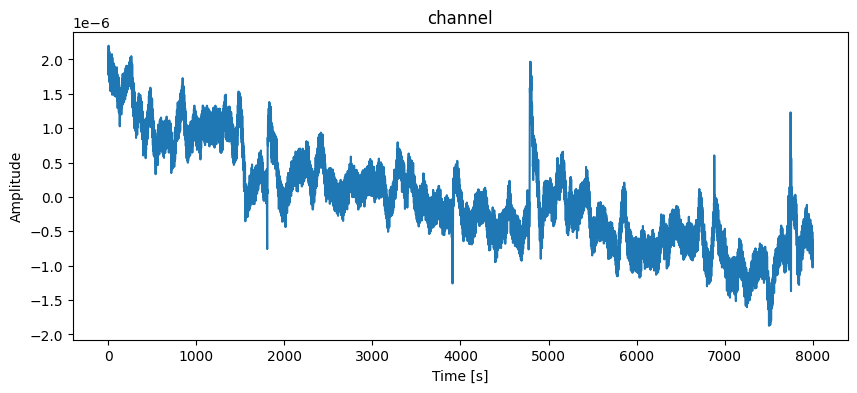

<Figure size 640x480 with 0 Axes>

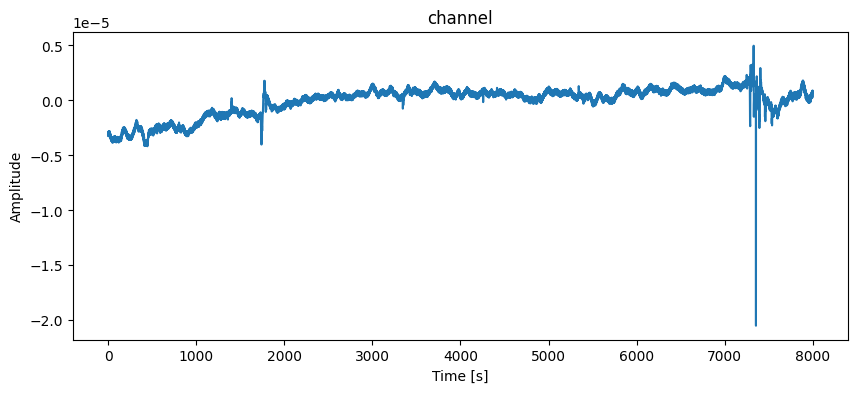

[False False False ... False False False]
(8000,)


<Figure size 640x480 with 0 Axes>

In [113]:
def load_snirf_data(folder_path, ID=0):
    raw_data_array = []
    if os.path.isdir(folder_path):
        for file_name in os.listdir(folder_path):
            if file_name.endswith('.snirf'):

                snirf_file_path = os.path.join(folder_path, file_name)
                raw_object = mne.io.read_raw_snirf(snirf_file_path, verbose=False)
                
                annotation = mne.Annotations(onset=[0], duration=[raw_object.times[-1]  - raw_object.times[0]], description=[f"Subject ID: {ID}"])
                # Onset starts at 0, the start, and duration is until the last sample (so covers the whole thing)
                ID += 1

                raw_object.set_annotations(annotation)
                raw_data_array.append(raw_object)
    
    return raw_data_array


def get_time_series_from_snirf_data(snirf_file_path):
    raw_object = mne.io.read_raw_snirf(snirf_file_path, verbose=False)
    raw_object.load_data()
    
    # Removes short channels. They're useful for my single channel denoising program since they can't pick up hrf.
    raw_picks = mne.pick_types(raw_object.info, meg = False, fnirs = True)
    channel_distances = mne.preprocessing.nirs.source_detector_distances(raw_object.info, picks = raw_picks)
    raw_object.pick(raw_picks[channel_distances > 0.01])

    optical_density = mne.preprocessing.nirs.optical_density(raw_object)
    haemo_recording = mne.preprocessing.nirs.beer_lambert_law(optical_density, ppf=6)
    haemo_data = haemo_recording.get_data()
    print(np.shape(haemo_data))
    
    return haemo_data

links = ["/Users/kostasdemiris/Downloads/snirf/RS4_SL_4252.snirf", "/Users/kostasdemiris/Downloads/snirf/RS4_SL_4269.snirf",
        "/Users/kostasdemiris/Downloads/snirf/RS4_SL_4296.snirf", "/Users/kostasdemiris/Downloads/snirf/RS4_SL_4283.snirf",
        "/Users/kostasdemiris/Downloads/snirf/RS4_SL_4352.snirf", "/Users/kostasdemiris/Downloads/snirf/RS4_SL_4360.snirf"]

tester_data_link = "/Users/kostasdemiris/Downloads/snirf/RS4_SL_4310.snirf"

time_state_data = np.array(get_time_series_from_snirf_data("/Users/kostasdemiris/Downloads/snirf/RS4_SL_4219.snirf"))[:, :8000]
time_state_datas = []
time_state_datas.append(time_state_data)
for link in links:
    time_state_datas.append(np.array(get_time_series_from_snirf_data(link))[:, :8000])
time_state_datas = np.array(time_state_datas)
displays.plot_pChannel(time_state_data[2], np.arange(0, len(time_state_data[0]-1)))
displays.plot_pChannel(time_state_datas[4, 2], np.arange(0, len(time_state_data[0]-1)))
print(time_state_datas[1][0] == time_state_data[0])
print(np.shape(time_state_datas[3][0]))

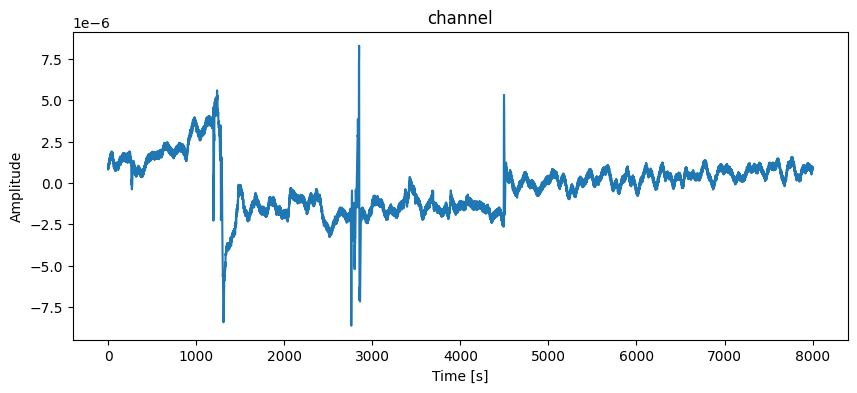

<Figure size 640x480 with 0 Axes>

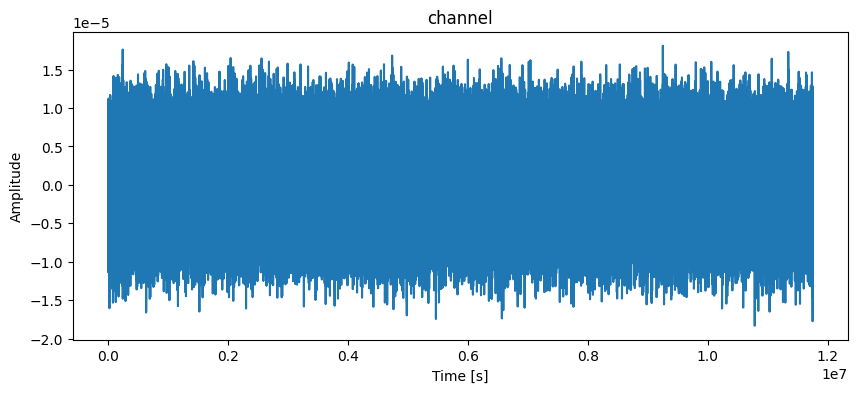

<Figure size 640x480 with 0 Axes>

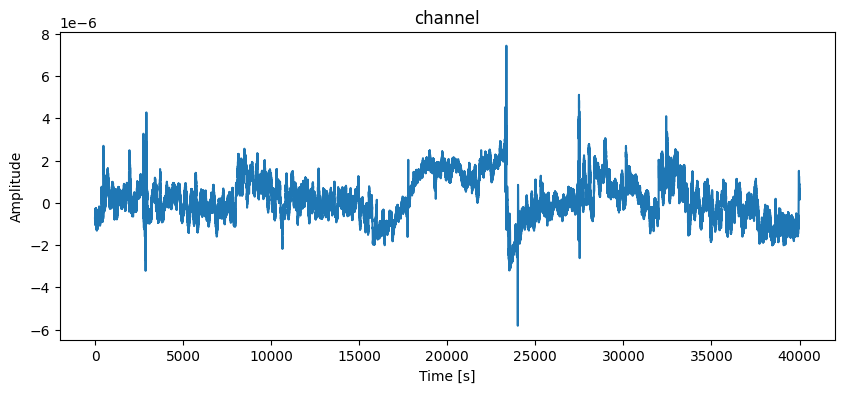

3.7610722532260425e-06 7.39202230533662e-08
1.0048873974997952e-06 2.260012448363354e-07


<Figure size 640x480 with 0 Axes>

In [550]:
displays.plot_pChannel(time_state_datas[1][0], np.arange(0, len(time_state_data[0] - 1)))

base_state_value, differenced_data = time_state_data[0][0], diff.difference(time_state_data[0])
# displays.plot_pChannel(differenced_data, np.arange(0, len(time_state_data[0] - 1)))

# pACF_result = stats.partial_autocorrelation_test(time_state_data[0])
# ACF_result = stats.autocorrelation_test(time_state_data[0])

# displays.plot_pChannel(pACF_result, range(len(pACF_result)))
# displays.plot_pChannel(ACF_result, range(len(ACF_result)))
# print(diff.augmented_Dickey_Fuller_test(time_state_data[0]), diff.augmented_Dickey_Fuller_test(differenced_data))
ar_rsd = Auto_Regressive_Model(6)
# Autoregressive model for resting state data (rsd)

base_state_val, differenced_state_data = time_state_data[0][0], diff.difference(time_state_data[0])

ar_rsd.fit(np.concatenate(time_state_datas[2:, 0]))
data_to_use = ar_rsd.predict(np.concatenate(time_state_datas[:, 1]), 235 * 50000, 3, iterative_averaging=True)
data_to_use_2 = ar_rsd.predict(np.concatenate(time_state_datas[:, 1]), 235 * 50000, 3, iterative_averaging=True)
displays.plot_pChannel(data_to_use, np.arange(len(data_to_use)))
displays.plot_pChannel(np.concatenate(time_state_datas[2:, 1]), np.arange(0, len(np.concatenate(time_state_datas[2:, 1]) - 1)))

# ar_rsd.fit(differenced_data)
# undiffed_data = diff.inv_difference(base_state_val, ar_rsd.predict(differenced_data, len(differenced_data), 200, iterative_averaging=True))
# displays.plot_pChannel(diff.inv_difference(base_state_val, differenced_data), range(len(differenced_data)))
# displays.plot_pChannel(undiffed_data, range(len(undiffed_data)))
print(np.std(data_to_use), np.mean(data_to_use))
print(np.std(np.concatenate(time_state_datas[2: , 1])), np.mean(np.concatenate(time_state_datas[2:, 1])))
# displays.plot_pChannel(diff.inv_difference(base_state_value, differenced_data), np.arange(0, len(time_state_data[0] - 1)))


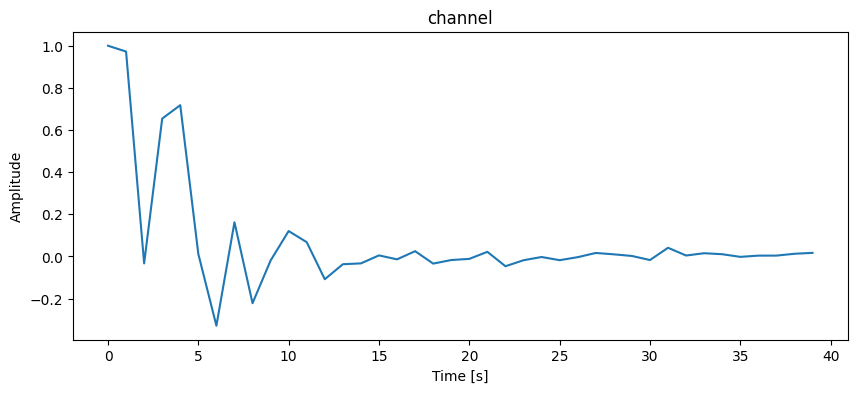

<Figure size 640x480 with 0 Axes>

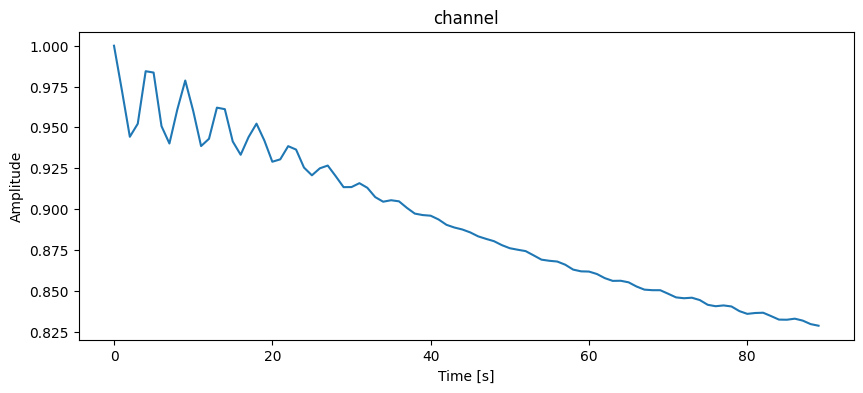

[ 1.          0.97237795 -0.03279111  0.65421969  0.71793529  0.01188766
 -0.32849708  0.16240107 -0.22165915 -0.01914818  0.12067759  0.06793751
 -0.10796593 -0.03670346 -0.03270276  0.00516898 -0.01352145  0.02520045
 -0.03376826 -0.01681245 -0.01131266  0.02203753 -0.04624099 -0.01781723
 -0.00244708 -0.01752346 -0.00322337  0.01675635  0.01021531  0.00251698
 -0.01689838  0.04132581  0.0046237   0.01547606  0.0107615  -0.0017736
  0.00406966  0.00421081  0.01291438  0.01721124]


<Figure size 640x480 with 0 Axes>

In [108]:
pACF_result = stats.partial_autocorrelation_test(time_state_datas[0][0])
ACF_result = stats.autocorrelation_test(time_state_datas[0][0])
displays.plot_pChannel(pACF_result, range(len(pACF_result)))
displays.plot_pChannel(ACF_result, range(len(ACF_result)))
print(pACF_result)

In [ ]:
print(np.std(data_to_use), np.mean(data_to_use))
print(np.std(time_state_data[0]), np.mean(time_state_data))

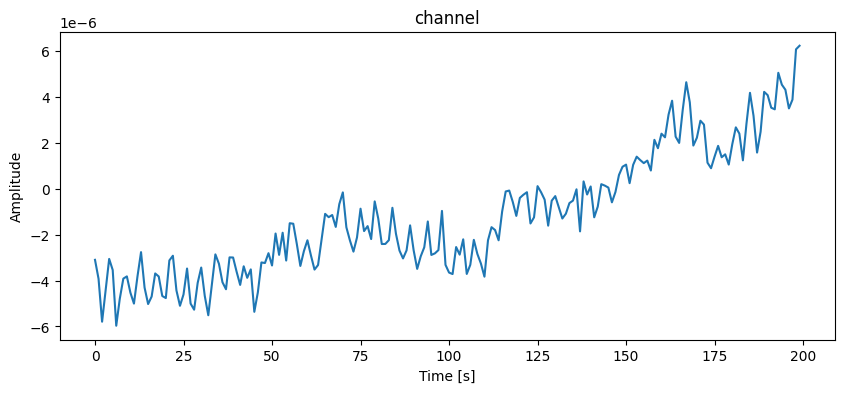

9.69581646651203e-08


<Figure size 640x480 with 0 Axes>

In [405]:
ra = random.randint(0, len(data_to_use) - 1)
displays.plot_pChannel(data_to_use[ra: ra+ 200], range(200))
print(np.mean(data_to_use))
# displays.plot_pChannel(time_state_data[0][ra: ra+ 200], range(200))

In [9]:
# Data sample segmenetation:

def return_seg_sample(sample_tape, sample_len):
    # By the way, this will only return full size samples, so if len(sample_tape) % sample_len != 0, some data will be cut off the end
    assert(len(sample_tape) > sample_len and sample_len > 0)
    
    lcm_n_k = (len(sample_tape) // sample_len) * sample_len # Truncates sample tape of len n to the largest common multiple with sample length k
    trunc_sample = np.array(sample_tape[:lcm_n_k])
    seg_samples = trunc_sample.reshape(-1, sample_len)
    
    return seg_samples

def return_rand_samples(sample_tape, sample_num, sample_len):
    assert(len(sample_tape) > sample_len and sample_len > 0 and sample_num >= 0)
    
    samples = []
    for sample in range(sample_num):
        rand_index = random.randint(0, len(sample_tape) - sample_len)
        samples.append(sample_tape[rand_index: rand_index + sample_len])
    
    return samples

In [491]:
testers = generator.gen_hrf_set(10)


Index is currently 0
Used Annotations descriptions: ['A']


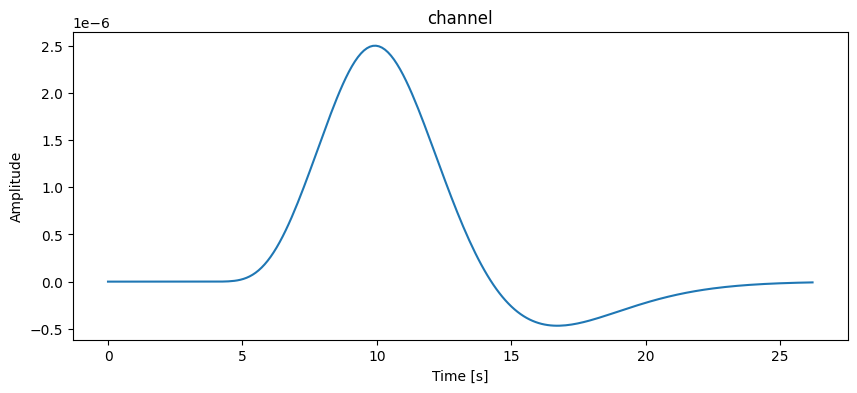

<Figure size 640x480 with 0 Axes>

In [494]:
displays.plot_pChannel(testers[6][:235], time_signal[:235])

84 is the number of hrf's we're going to be generating with a total sample number of 169
(169, 236)
7.863043559714257e-07 2.05141731806537e-08


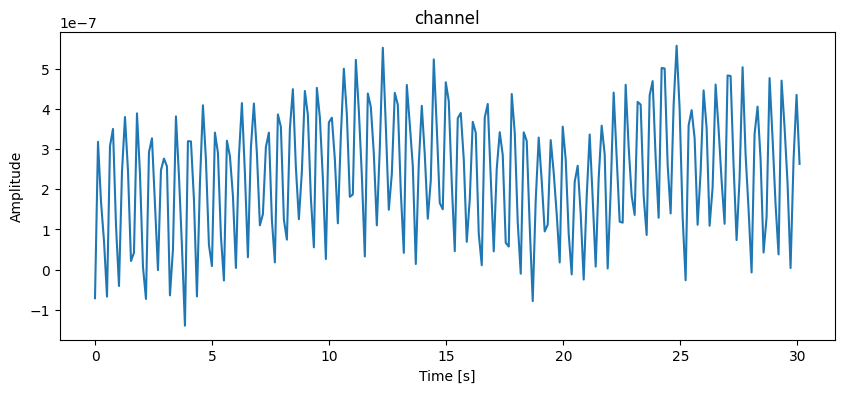

Index is currently 0
Used Annotations descriptions: ['A']
Index is currently 60
Used Annotations descriptions: ['A']


<Figure size 640x480 with 0 Axes>

In [10]:
# Real sample_data to train with for evaluation
sample_length = 236
real_samples = return_seg_sample(np.concatenate(time_state_data[:5]), sample_length)
hrf_number = len(real_samples)

print(hrf_number//2, "is the number of hrf's we're going to be generating with a total sample number of", hrf_number)
# real_samples = return_seg_sample(time_state_data[0], sample_length)

print(np.shape(real_samples))
print(np.std(real_samples), np.mean(real_samples))
displays.plot_pChannel(real_samples[random.randint(0, len(real_samples) - 1)], time_signal)

sample_hrf_overlay = generator.gen_hrf_set(len(real_samples) // 2)
sample_empty_overlay = np.zeros((len(real_samples) - (len(real_samples) // 2), len(sample_hrf_overlay[0])))
half_hrf_set = np.random.shuffle(np.concatenate((sample_hrf_overlay, sample_empty_overlay)))

In [11]:
# Data Generation models
class Auto_Regressive_Model():
    # Uses the direct relation between the previous k (order) values to forecast the subsequent value in a time series
    # Suitable for when the ACF plot has a slowly decreasing tail, with the highest significant PACF value being order
    def __init__(self, order):
        self.k = order
        self.model = LinearRegression()
        self.std = None
    
    def generate_training_data(self, data):
        # returns the inp. data, an array of k long sequences, and outp. data, array of the respective k+i+1'th values
        n = len(data)
                
        x_data = np.reshape(data[:n - self.k], (-1, 1))
        for i in range(1, self.k):
            x_data = np.hstack((x_data, np.reshape(data[i: n - self.k + i], (-1, 1))))

        y_data = data[self.k:]
        return np.array(x_data), np.array(y_data)
    
    def fit(self, data):
        self.std = np.std(data)
        training_x, training_y = self.generate_training_data(data)
        self.model.fit(training_x, training_y)
    
    def predict(self, data, steps, mc_depth, iterative_averaging=False):
        # Steps refers the number of points that it will return in the future, and mc_depth is the number of monte 
        # carlo simulations that we'll average to return the data
        assert(mc_depth > 0 and steps > 0)
        
        inputted, output = np.array(data), []
        tape = inputted[-self.k:]
        if iterative_averaging:
            # This approach predicts the next value r (mc_depth) times, then averages that and uses it as the subq. input
            # reduces compounding error from consecutive inaccurate predictions, but is more comp. expensive and still 
            # can have bias if it accumalates over many predictions.
            for step in range(steps):
                temp_next = 0
                
                for sim in range(mc_depth):
                    temp_next += (self.model.predict(np.reshape(tape, (1, -1))).item() + np.random.normal(scale = self.std))
                    # we add an error term to prediction to conser the unpredictability and also for some non-determinism
                
                tape = np.roll(tape, -1)
                next_point = temp_next / mc_depth
                tape[-1] = next_point
                output.append(next_point)
            
            output = np.array(output)
            
        else:
            # averaging r (mc_depth) different simulations of k (order) points
            
            output_acc = np.array([])
            # Accumulates all of the simulations
            
            for sim in range(mc_depth):
                tape = inputted[-self.k:]
                temp_output = []
                
                for step in range(steps):
                    temp_next = self.model.predict(np.reshape(tape, (1, -1))).item() + np.random.normal(scale = self.std)
                    temp_output.append(temp_next)
                    
                    tape = np.roll(tape, -1)
                    tape[-1] = (temp_next)
                    
                if sim == 0:
                    output_acc = np.array(temp_output)
                else:
                    output_acc += np.array(temp_output)
            
            output = output_acc / mc_depth 
        
        return output
    
class Differencer():
    # Converts non stationairy (properties change depend on time period of observation) data to stationairy data
    # by taking the change in the data (each point becomes the difference between itself and the previous value)
    # k (order) times.
    def __init__(self):
        pass
    
    def augmented_Dickey_Fuller_test(self, data, sig_lev=0.05):
        # the ADF test, useful for finding the order of differences that are necessary to produce stationairy data.
        # returns whether the data at this level of difference is stationairy. Statistics so is inaccurate at small sample sizes
        result = adfuller(data)
        # result[1] is the p value of the test, and if it is less than 0.05, the data is significant and we reject h0
        # so no unit root ergo it's stationairy
        return (result[1] < sig_lev)

    
    def stationairy_conv(self, data, significance_level=0.05):
        output = np.array(data)
        while not self.augmented_Dickey_Fuller_test(output, sig_lev = significance_level):
            output = self.difference(output)
            
        return output
    
    def difference(self, data):
        base = np.array(data)
        return np.concatenate((np.zeros(1), base[1:] - base[:-1]))
    
    def inv_difference(self, original, differenced_data, order=1):
        differenced_data[0] = original
        for i in range(order):
            differenced_data = np.cumsum(differenced_data)
        return differenced_data

In [12]:
class CWH_ToTensor:
    # Channels, then width then height. Basic toTensor() from transforms does not support data of my shape.
    def __call__(self, x):
        return torch.tensor(x, dtype=torch.float32)

class Log_Transform:
    def __call__(self, data, base = norm_base):
        return np.emath.logn(base, data) .astype('float32')
    # This doesn't need an adjustment for zero because np.log1p just returns zero for that.
    # An adjustment would also throw very big errors in because a small adjustment would mean very negative outputs.
        

pad_log_transform = transforms.Compose([
#     Log_Transform(),
    CWH_ToTensor()
])

simple_to_tensor = transforms.Compose([
    transforms.Lambda(lambda x: x.astype('float32')),
    transforms.ToTensor()
]
)

In [13]:
# class Linear_regressor(torch.nn.Module):
#     # https://towardsdatascience.com/linear-regression-with-pytorch-eb6dedead817 <-- tutorial for this
#     def __init__(self):
#         super().__init__()  
#         self.linear_layer = None
    
#     def forward(self, x):
#         pred = self.linear_layer(x)
#         return pred
    
#     def fit(self, x_train, y_train, epoch_num=50):
#         print(np.shape(x_train), np.shape(y_train))
#         # Only works with one dimensional data because I don't need it to do anything beyond that.
#         self.linear_layer = torch.nn.Linear(len(x_train[0]), len(y_train[0]))
#         loss_func = torch.nn.MSELoss() 
#         optimiser = torch.optim.SGD(self.parameters(), lr=1e-4)
        
#         for epoch in range(epoch_num):
#             inputs = Variable(torch.from_numpy(x_train))
#             labels = Variable(torch.from_numpy(y_train))
            
#             optimiser.zero_grad()
#             outputs = self(inputs)
            
#             pred_loss = loss_func(outputs, labels)
#             pred_loss.backward()
#             optimiser.step()
            
#         print(f"Final loss of {pred_loss.item()%.4}")
        
#     def predict(self, tape):
#         return self(torch.from_numpy(tape))
    
# class AutoRegression:
#     def __init__(self, order):
#         self.order = order 
#         # The order of an AutoRegression model is the number of previous variables used to calculate the next one
#         self.model = Linear_regressor()
#         self.std = None
        
#     def generate_predictor_data(self, data_set):
#         n = len(data_set)
        
#         data = data_set[:n - self.order]
#         data = np.reshape(data, (-1, 1))
        
#         # This takes the values from index 0 up to n-order and reshapes them into a column vector 
#         # We then stack the values from index 1 to (n-order) + 1. 
        
#         # If we hadn't done 0 independently, we'd have nothing to stack onto
#         for i in range(1, self.order):
#             temp_col = data_set[i:(n+i) - self.order]
#             temp_col = np.reshape(temp_col, (-1, 1))
#             np.hstack((data, temp_col))
            
#         return data
    
#     def generate_responce_data(self, data_set):
#         return data_set[self.order:]
    
#     def fit(self, data_set):
#         self.std = np.std(data_set)
#         t_x_data = self.generate_predictor_data(data_set)  # X data for training
#         t_y_data = self.generate_responce_data(data_set)  # Y data for training
#         self.model.fit(t_x_data, t_y_data)
        
#     def predict(self, data_set, step_count, simulation_num):
#         data_set = np.array(data_set)
#         output = np.array([])
        
#         for sim in range(simulation_num):
#             # We do a monte carlo simulation approach, performing a bunch of simulations, then averaging them
#             temp_ans = []
#             tape = data_set[-self.order:]
#             # Take the last order num values as a rolling tape measure, then keep rolling back to the start
#             # along the tape, putting in our predicted values in as we go
            
#             for prediction in range(step_count):
#                 predicted = self.model.predict(np.reshape(tape, (-1, 1)))
#                 predicted += np.random.normal(loc=0, scale=self.std)
#                 # We predict the next value, then add some gaussian noise to it depending on the standard
#                 # deviation of the original dataset we were using...
                
#                 temp_ans.append(predicted[0].detach().numpy())
#                 tape = np.roll(tape, -1) 
#                 # We move the tape backwards by one, the last value becomes the second to last and so forth
#                 tape[-1] = predicted[0].detach().numpy()
                
#             if sim == 0:
#                 output = np.array(temp_ans)
#             else:
#                 output = output + np.array(temp_ans)
#                 # since we'll be averaging out the values anyway, just add them elementwise for now
#         output = output/ simulation_num
#         return output    
    
    
# auto_regression = AutoRegression(5)


In [280]:
target, overlay = generator.generate_basic_test_data(10000)
dummy_target, more_overlay = np.zeros(np.shape(target)), generator.gen_overlay_data(len(overlay), len(overlay[0]))

target_2 = np.concatenate((target, dummy_target))
overlay_2 = np.concatenate((overlay, more_overlay))

np.random.shuffle(target_2)
np.random.shuffle(overlay_2)

eval_target, eval_overlay = generator.generate_basic_test_data(250)
test_target, test_overlay = generator.generate_basic_test_data(500)

Index is currently 0
Used Annotations descriptions: ['A']
Index is currently 62
Used Annotations descriptions: ['A']
Index is currently 120
Used Annotations descriptions: ['A']
Index is currently 180
Used Annotations descriptions: ['A']
Index is currently 241
Used Annotations descriptions: ['A']
Index is currently 302
Used Annotations descriptions: ['A']
Index is currently 365
Used Annotations descriptions: ['A']
Index is currently 424
Used Annotations descriptions: ['A']
Index is currently 487
Used Annotations descriptions: ['A']
Index is currently 544
Used Annotations descriptions: ['A']
Index is currently 604
Used Annotations descriptions: ['A']
Index is currently 664
Used Annotations descriptions: ['A']
Index is currently 721
Used Annotations descriptions: ['A']
Index is currently 779
Used Annotations descriptions: ['A']
Index is currently 837
Used Annotations descriptions: ['A']
Index is currently 897
Used Annotations descriptions: ['A']
Index is currently 957
Used Annotations des

Index is currently 8108
Used Annotations descriptions: ['A']
Index is currently 8167
Used Annotations descriptions: ['A']
Index is currently 8229
Used Annotations descriptions: ['A']
Index is currently 8286
Used Annotations descriptions: ['A']
Index is currently 8347
Used Annotations descriptions: ['A']
Index is currently 8406
Used Annotations descriptions: ['A']
Index is currently 8465
Used Annotations descriptions: ['A']
Index is currently 8522
Used Annotations descriptions: ['A']
Index is currently 8585
Used Annotations descriptions: ['A']
Index is currently 8646
Used Annotations descriptions: ['A']
Index is currently 8707
Used Annotations descriptions: ['A']
Index is currently 8770
Used Annotations descriptions: ['A']
Index is currently 8831
Used Annotations descriptions: ['A']
Index is currently 8891
Used Annotations descriptions: ['A']
Index is currently 8952
Used Annotations descriptions: ['A']
Index is currently 9011
Used Annotations descriptions: ['A']
Index is currently 9070


In [284]:
dummy_test_target, more_test_overlay = np.zeros(np.shape(test_target)), generator.gen_overlay_data(len(test_overlay), len(test_overlay[0]))

test_target_2 = np.concatenate((test_target, dummy_test_target))
test_overlay_2 = np.concatenate((test_overlay, more_test_overlay))

np.random.shuffle(test_target_2)
np.random.shuffle(test_overlay_2)



In [170]:
# Real data version
overlay = return_seg_sample(np.concatenate((data_to_use[:5, 0])), 235)
target = generator.gen_hrf_set(len(overlay), sample_length = 235)

test_target = generator.gen_hrf_set(125, sample_length = 235)
test_overlay = return_rand_samples(time_state_datas[5, 0], 500, 235)

eval_target = generator.gen_hrf_set(125, sample_length = 235)
eval_overlay = return_rand_samples(time_state_datas[5, 0], 500, 235)


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [551]:
# AR generated data version
overlay = return_seg_sample(data_to_use, 235)
test_overlay = return_rand_samples(data_to_use, 500, 235)
target = generator.gen_hrf_set(len(overlay), sample_length = 235)

print(np.shape(overlay), np.shape(more_overlay), np.shape(target), np.shape(target_2))

dummy_target, more_overlay = np.zeros(np.shape(target)), return_seg_sample(data_to_use_2, 235)

target_2 = np.concatenate((target, dummy_target[:, :235]))
overlay_2 = np.concatenate((overlay, more_overlay))

test_target_2 = np.concatenate((test_target, dummy_test_target))[:, :235]
test_overlay_2 = np.concatenate((test_overlay, more_test_overlay[:, :235]))

np.random.shuffle(test_target_2)
np.random.shuffle(test_overlay_2)
print(np.shape(target_2), np.shape(overlay_2))
print(np.shape(test_target_2), np.shape(test_overlay_2))

Index is currently 0
Used Annotations descriptions: ['A']
Index is currently 61
Used Annotations descriptions: ['A']
Index is currently 119
Used Annotations descriptions: ['A']
Index is currently 181
Used Annotations descriptions: ['A']
Index is currently 240
Used Annotations descriptions: ['A']
Index is currently 300
Used Annotations descriptions: ['A']
Index is currently 359
Used Annotations descriptions: ['A']
Index is currently 421
Used Annotations descriptions: ['A']
Index is currently 480
Used Annotations descriptions: ['A']
Index is currently 538
Used Annotations descriptions: ['A']
Index is currently 597
Used Annotations descriptions: ['A']
Index is currently 654
Used Annotations descriptions: ['A']
Index is currently 714
Used Annotations descriptions: ['A']
Index is currently 774
Used Annotations descriptions: ['A']
Index is currently 835
Used Annotations descriptions: ['A']
Index is currently 897
Used Annotations descriptions: ['A']
Index is currently 955
Used Annotations des

Index is currently 8088
Used Annotations descriptions: ['A']
Index is currently 8150
Used Annotations descriptions: ['A']
Index is currently 8210
Used Annotations descriptions: ['A']
Index is currently 8270
Used Annotations descriptions: ['A']
Index is currently 8331
Used Annotations descriptions: ['A']
Index is currently 8391
Used Annotations descriptions: ['A']
Index is currently 8454
Used Annotations descriptions: ['A']
Index is currently 8515
Used Annotations descriptions: ['A']
Index is currently 8575
Used Annotations descriptions: ['A']
Index is currently 8634
Used Annotations descriptions: ['A']
Index is currently 8695
Used Annotations descriptions: ['A']
Index is currently 8752
Used Annotations descriptions: ['A']
Index is currently 8813
Used Annotations descriptions: ['A']
Index is currently 8874
Used Annotations descriptions: ['A']
Index is currently 8935
Used Annotations descriptions: ['A']
Index is currently 8997
Used Annotations descriptions: ['A']
Index is currently 9059


Index is currently 16089
Used Annotations descriptions: ['A']
Index is currently 16149
Used Annotations descriptions: ['A']
Index is currently 16208
Used Annotations descriptions: ['A']
Index is currently 16271
Used Annotations descriptions: ['A']
Index is currently 16332
Used Annotations descriptions: ['A']
Index is currently 16391
Used Annotations descriptions: ['A']
Index is currently 16447
Used Annotations descriptions: ['A']
Index is currently 16507
Used Annotations descriptions: ['A']
Index is currently 16570
Used Annotations descriptions: ['A']
Index is currently 16630
Used Annotations descriptions: ['A']
Index is currently 16692
Used Annotations descriptions: ['A']
Index is currently 16754
Used Annotations descriptions: ['A']
Index is currently 16817
Used Annotations descriptions: ['A']
Index is currently 16877
Used Annotations descriptions: ['A']
Index is currently 16937
Used Annotations descriptions: ['A']
Index is currently 16995
Used Annotations descriptions: ['A']
Index is

Used Annotations descriptions: ['A']
Index is currently 24086
Used Annotations descriptions: ['A']
Index is currently 24144
Used Annotations descriptions: ['A']
Index is currently 24207
Used Annotations descriptions: ['A']
Index is currently 24266
Used Annotations descriptions: ['A']
Index is currently 24329
Used Annotations descriptions: ['A']
Index is currently 24388
Used Annotations descriptions: ['A']
Index is currently 24450
Used Annotations descriptions: ['A']
Index is currently 24510
Used Annotations descriptions: ['A']
Index is currently 24566
Used Annotations descriptions: ['A']
Index is currently 24626
Used Annotations descriptions: ['A']
Index is currently 24686
Used Annotations descriptions: ['A']
Index is currently 24744
Used Annotations descriptions: ['A']
Index is currently 24806
Used Annotations descriptions: ['A']
Index is currently 24867
Used Annotations descriptions: ['A']
Index is currently 24929
Used Annotations descriptions: ['A']
Index is currently 24988
Used Ann

Index is currently 32006
Used Annotations descriptions: ['A']
Index is currently 32066
Used Annotations descriptions: ['A']
Index is currently 32128
Used Annotations descriptions: ['A']
Index is currently 32193
Used Annotations descriptions: ['A']
Index is currently 32252
Used Annotations descriptions: ['A']
Index is currently 32312
Used Annotations descriptions: ['A']
Index is currently 32370
Used Annotations descriptions: ['A']
Index is currently 32430
Used Annotations descriptions: ['A']
Index is currently 32491
Used Annotations descriptions: ['A']
Index is currently 32550
Used Annotations descriptions: ['A']
Index is currently 32609
Used Annotations descriptions: ['A']
Index is currently 32669
Used Annotations descriptions: ['A']
Index is currently 32729
Used Annotations descriptions: ['A']
Index is currently 32790
Used Annotations descriptions: ['A']
Index is currently 32851
Used Annotations descriptions: ['A']
Index is currently 32908
Used Annotations descriptions: ['A']
Index is

Used Annotations descriptions: ['A']
Index is currently 39981
Used Annotations descriptions: ['A']
Index is currently 40040
Used Annotations descriptions: ['A']
Index is currently 40100
Used Annotations descriptions: ['A']
Index is currently 40160
Used Annotations descriptions: ['A']
Index is currently 40218
Used Annotations descriptions: ['A']
Index is currently 40277
Used Annotations descriptions: ['A']
Index is currently 40339
Used Annotations descriptions: ['A']
Index is currently 40400
Used Annotations descriptions: ['A']
Index is currently 40459
Used Annotations descriptions: ['A']
Index is currently 40521
Used Annotations descriptions: ['A']
Index is currently 40580
Used Annotations descriptions: ['A']
Index is currently 40639
Used Annotations descriptions: ['A']
Index is currently 40699
Used Annotations descriptions: ['A']
Index is currently 40757
Used Annotations descriptions: ['A']
Index is currently 40817
Used Annotations descriptions: ['A']
Index is currently 40874
Used Ann

Index is currently 47870
Used Annotations descriptions: ['A']
Index is currently 47929
Used Annotations descriptions: ['A']
Index is currently 47987
Used Annotations descriptions: ['A']
Index is currently 48047
Used Annotations descriptions: ['A']
Index is currently 48103
Used Annotations descriptions: ['A']
Index is currently 48161
Used Annotations descriptions: ['A']
Index is currently 48222
Used Annotations descriptions: ['A']
Index is currently 48279
Used Annotations descriptions: ['A']
Index is currently 48341
Used Annotations descriptions: ['A']
Index is currently 48406
Used Annotations descriptions: ['A']
Index is currently 48467
Used Annotations descriptions: ['A']
Index is currently 48528
Used Annotations descriptions: ['A']
Index is currently 48588
Used Annotations descriptions: ['A']
Index is currently 48649
Used Annotations descriptions: ['A']
Index is currently 48706
Used Annotations descriptions: ['A']
Index is currently 48766
Used Annotations descriptions: ['A']
Index is

In [552]:
print(np.mean(test_target), np.mean(test_overlay))
print(np.std(target), np.std(overlay))



7.48849208889597e-07 2.71054855762536e-08
1.094812362735134e-06 3.7610722532260425e-06


(268,) (10000, 268)


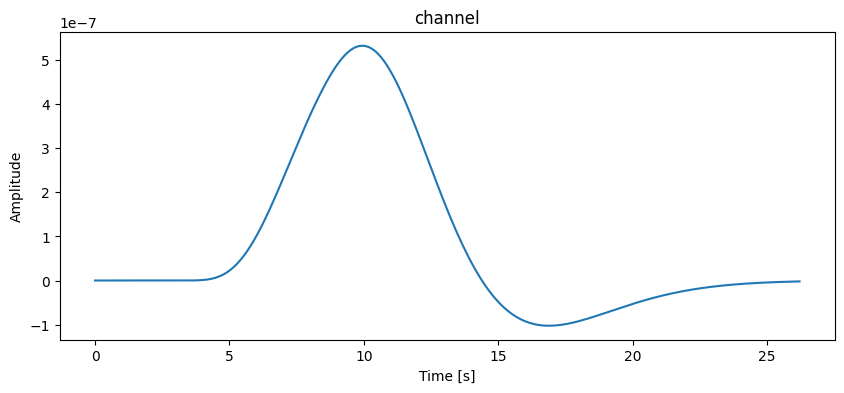

<Figure size 640x480 with 0 Axes>

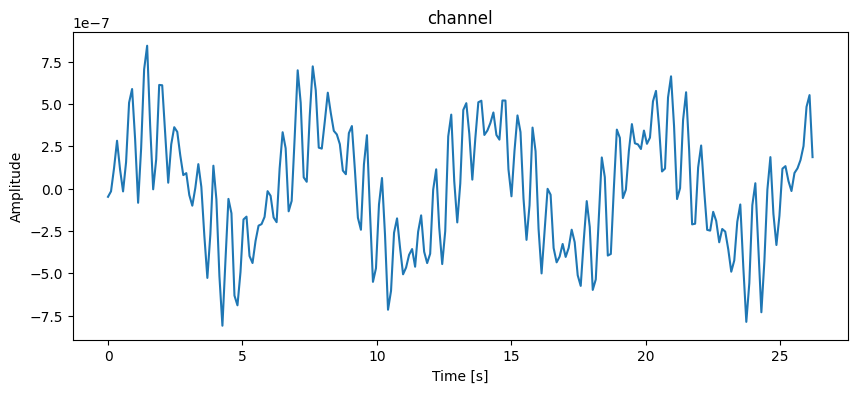

<Figure size 640x480 with 0 Axes>

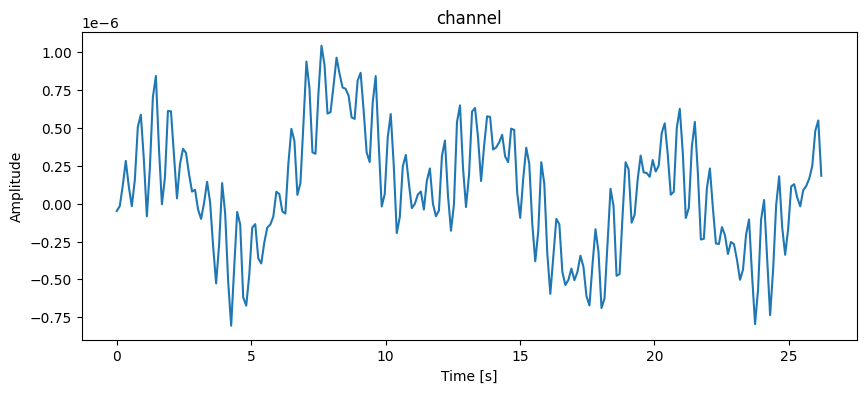

<Figure size 640x480 with 0 Axes>

In [192]:
print(np.shape(target[0]), np.shape(target))
displays.plot_pChannel(target[4][:235], time_signal[:235])
displays.plot_pChannel(overlay[4][:235], time_signal[:235])
displays.plot_pChannel(target[4][:235] + overlay[4][:235], time_signal[:235])


In [ ]:
# Real sample_data to train with for evaluation
sample_length = 236
real_samples = return_seg_sample(np.concatenate(time_state_data[:5]), sample_length)
hrf_number = len(real_samples)

print(hrf_number//2, "is the number of hrf's we're going to be generating with a total sample number of", hrf_number)
# real_samples = return_seg_sample(time_state_data[0], sample_length)

print(np.shape(real_samples))
print(np.std(real_samples), np.mean(real_samples))
displays.plot_pChannel(real_samples[random.randint(0, len(real_samples) - 1)], time_signal)

sample_hrf_overlay = generator.gen_hrf_set(len(real_samples) // 2)
sample_empty_overlay = np.zeros((len(real_samples) - (len(real_samples) // 2), len(sample_hrf_overlay[0])))
half_hrf_set = np.random.shuffle(np.concatenate((sample_hrf_overlay, sample_empty_overlay)))

In [544]:
class padded_wavelet_database:
    def __init__(self, clean, overlays, transform=pad_log_transform, base = norm_base, add_len = 0,
                 inherit_params = None, mag_reduc = False):
        # Both clean and overlays (which is clean + noise) are in wavelet form by the way
        self.lengths = np.array([len(row) for row in clean[0]])
        self.add_len = add_len
        
        self.unnorm_clean = self.pad(clean, max(self.lengths), add_len = add_len)
        self.unnorm_dirty = self.pad(overlays, max(self.lengths), add_len = add_len) #+ self.clean
        
        
        self.transform = pad_log_transform
        self.mag_reduc = mag_reduc # Whether to use the logarithmic magnitude reduction method, which currently still has issues
        
        self.band_priorities = np.array([1 for band in range(len(clean[0]))])
        self.priority_bias = False # A flag that tells us whether there is a priority bias applied on the bands, for get_signal_back...

        # Lets us use another dataset's parameters to normalise this one, for training purposes
        if self.mag_reduc:
            if inherit_params is None:
                self.min_order_mag = norms.get_min_order_of_magnitude(np.copy(self.unnorm_dirty)- 1)
                self.param_set = norms.logarithmic_magnitude_reduction(np.copy(self.unnorm_dirty), magnitude_correction = self.min_order_mag)

            else:
                self.min_order_mag = norms.get_min_order_of_magnitude(np.copy(inherit_params) - 1)
                self.param_set = norms.logarithmic_magnitude_reduction(np.copy(inherit_params), magnitude_correction = self.min_order_mag)

            self.dirty = norms.per_band_wavelet_normalisation(
                norms.logarithmic_magnitude_reduction(np.copy(self.unnorm_dirty), magnitude_correction = self.min_order_mag), 
                    param_set=self.param_set)

            self.clean = norms.per_band_wavelet_normalisation(
                norms.logarithmic_magnitude_reduction(np.copy(self.unnorm_clean), magnitude_correction = self.min_order_mag),
                    param_set=self.param_set)
            
        else:
            self.min_order_mag = 0
            if inherit_params is None:
                self.param_set = np.copy(self.unnorm_dirty)
            else:
                self.param_set = np.copy(inherit_params)
                
            self.dirty = norms.per_band_wavelet_normalisation(
                np.copy(self.unnorm_dirty), param_set = self.param_set
            )
            self.clean = norms.per_band_wavelet_normalisation(
                np.copy(self.unnorm_clean), param_set = self.param_set
            )
            
            
        self.band_means = [np.mean(
            self.param_set[:, i][self.param_set[:, i] != 0])
                      for i in range(len(self.param_set[0]))]
        self.band_stds = [np.std(
            self.param_set[:, i][self.param_set[:, i] != 0])
                      for i in range(len(self.param_set[0]))]
        

        
    def __len__(self):
        return len(self.clean)
        
    def __getitem__(self, i):
        # Basically, the expected shape has one additional dimension, that of channels, that is not in my data, 
        # so i need to expand it by one so it has [channels (1), height, width]
        return (self.transform(np.expand_dims(self.clean[i].astype('float32'), axis=0)),
            self.transform(np.expand_dims(self.dirty[i].astype('float32'), axis=0)))
        
    
    def pad(self, wavedeck, max_length, add_len = 0):
        # wavedeck is an array of the products of a wavedec of the signal. (cause its a deck of wavedec's) 
        padded_wavedecs = np.array([
        [np.concatenate((np.array(row), np.zeros(max_length + add_len - len(row)))) 
             for row in signal] 
                for signal in wavedeck])
        return padded_wavedecs
    
    def get_signal_back(self, signal, original_lengths, base = norm_base):
        # At this point, it just runs through all the flags for different normalisation methods I've used on
        # padded set, and reverses them.
        recreation = []
        
        if self.priority_bias:
            print(np.shape(signal))
            signal = np.array([self.return_rev_priority(signal[0])])

        unnormalised_ver = norms.inv_per_band_wavelet_normalisation(signal, self.band_means, self.band_stds, 
                                magnitude_correction =  self.min_order_mag, expon = self.mag_reduc)[0]
        
        # (...)[0], because we added an extra dimension previously...

        for i, layer in enumerate(unnormalised_ver):
            recreation.append(layer[:original_lengths[i]])

        return convs.waverec(recreation) # Can sometimes give back signals that are too long, just cut to size.
    
    def old_get_signal_back(self, signal, original_lengths):
        # just depads, then waverecs. Doesn't consider normalisation. Not really used right now.
        recreation = []
        for i, layer in enumerate(signal[0]):
            # signal[0] because we added another dimension
            recreation.append(layer[:original_lengths[i]])
            
        return convs.waverec(recreation) # Can sometimes give back signals that are too long, just cut to size.
    
    
    def mass_signal_revert(self, signals, original_lengths):
        reverted_signals = []
        
        for signal in signals:
            reverted_signals = self.get_signal_back(signal, original_lengths)
            
        return np.array(reverted_signals)
    
    def set_band_priority(self, band_priorities):
        assert len(self.band_priorities) == len(band_priorities)
        self.band_priorities = band_priorities
    
    def apply_band_priority(self, priority_parameters = None, save=True):
        # This is another method to reduce the magnitude difference between bands, or otherwise determine which
        # bands get prioritized by the loss function. This is not covered by get_signal_back right now, and it
        # can be reversed by passing a priority set with inverses, or using rev_band_priority if it's using 
        # self.band_priorities
        
        if priority_parameters is None:
            priority_parameters = self.band_priorities
        
        assert len(priority_parameters) == len(self.band_priorities)
        if save == True:
            self.band_priorities = priority_parameters

        for i in range(len(priority_parameters)):
            self.clean[:, i] = self.clean[:, i] * priority_parameters[i]
            self.dirty[:, i] = self.dirty[:, i] * priority_parameters[i]
        
        self.priority_bias = True

    def rev_band_priority(self):
        rev_priority_bands = [1 / pri for pri in self.band_priorities]
        self.apply_band_priority(priority_parameters = rev_priority_bands, save=False)
        self.priority_bias = False

    def return_rev_priority(self, signal):
        rev_priority_bands = [1 / pri for pri in self.band_priorities]
        for i, band in enumerate(rev_priority_bands):
            signal[i] = signal[i] * band
        return signal
    
class simple_amplitude_database:
    def __init__(self, clean, overlays, transform=simple_to_tensor, base = norm_base):
        # Both clean and overlays are in the format of a time series of amplitudes
        self.clean = clean
        self.dirty = clean + overlays
        self.transform = transform
        
        self.min = np.min(self.dirty)
        self.max = np.max(self.dirty)
        self.mean = np.mean(self.dirty)
        self.std = np.std(self.dirty)
        
    def __len__(self):
        return len(self.dirty)
    
    def z_normalise(self, arr):
        return (arr - self.mean) / self.std
    
    def inv_z_normalise(self, arr):
        return (arr * self.std) + self.mean
        
    def __getitem__(self, i):
        clean_z_expanded = np.expand_dims(self.z_normalise(self.clean[i]), axis=0)
        dirty_z_expanded = np.expand_dims(self.z_normalise(self.dirty[i]), axis=0)
        
        clean_transformed = self.transform(clean_z_expanded)
        dirty_transformed = self.transform(dirty_z_expanded)

        return (clean_transformed[0],
               dirty_transformed[0])
        
class adapted_amplitude_database(simple_amplitude_database):
    def __init__(self, clean, overlay, transform=simple_to_tensor):
        super().__init__(clean, overlay, transform = transform)
        self.dirty_means = np.array([np.mean(dirty) for dirty in self.dirty])
        self.dirty_stds = np.array([np.std(dirty) for dirty in self.dirty])

    def __getitem__(self, i):
        dirty_mean, dirty_std = np.mean(self.dirty[i]), np.std(self.dirty[i])
        clean_z_expanded = np.expand_dims((self.clean[i] - self.dirty_means[i]) / self.dirty_stds[i], axis=0)
        dirty_z_expanded = np.expand_dims((self.dirty[i] - self.dirty_means[i]) / self.dirty_stds[i], axis=0)
        
        clean_transformed = self.transform(clean_z_expanded)
        dirty_transformed = self.transform(dirty_z_expanded)

        return (clean_transformed[0],
               dirty_transformed[0])
    
        

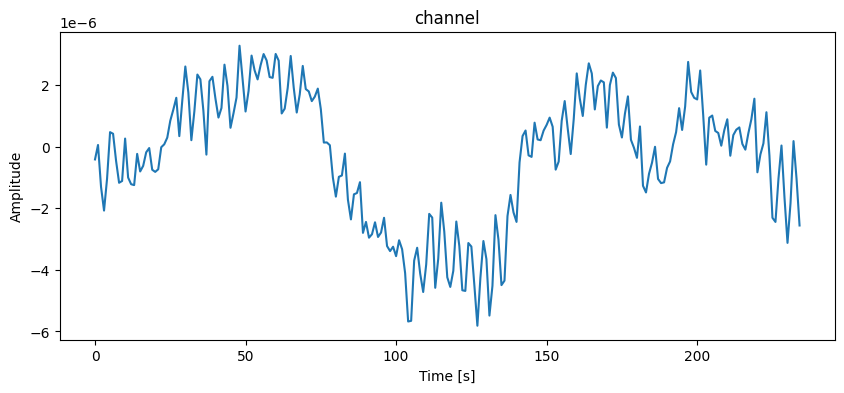

<Figure size 640x480 with 0 Axes>

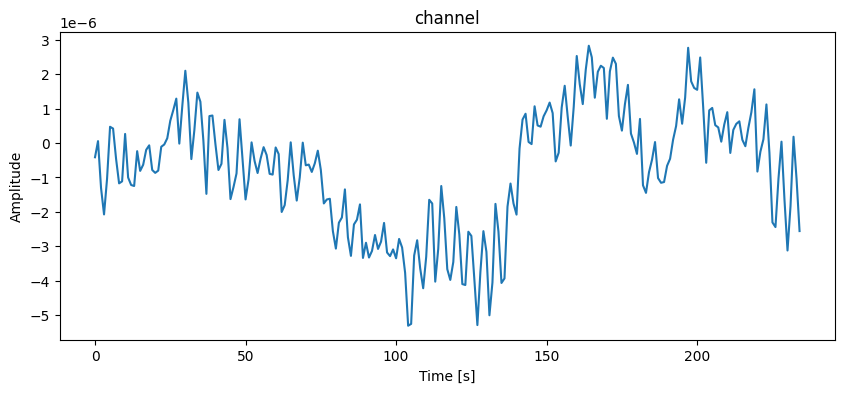

<Figure size 640x480 with 0 Axes>

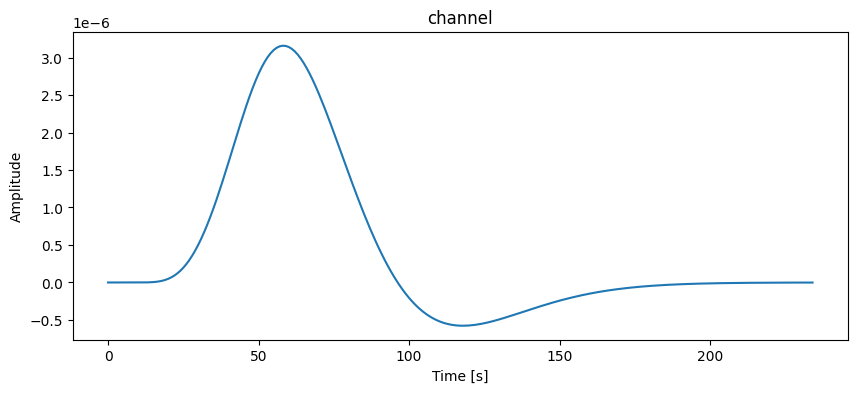

<Figure size 640x480 with 0 Axes>

In [500]:
# Examining the data

# target, overlay, test_target, test_overlay

displays.plot_pChannel(target[1] + overlay[1], range(len(overlay[0])))
displays.plot_pChannel(overlay[1], range(len(overlay[0])))
displays.plot_pChannel(target[1], range(len(target[0])))

In [553]:
# All of the setup code for the spectra representation versions

target_wavelets = [convs.wavedec(wave_signal) for wave_signal in target]
overlay_wavelets = [convs.wavedec(wave_signal) for wave_signal in (target + overlay)]
padded_set = padded_wavelet_database(target_wavelets, overlay_wavelets, add_len = 5, mag_reduc = False)

band_mag_priorities = np.array([1.5, 2, 3, 15, 200, 1200])
# Based on empirical values, not necessarily the best...
padded_set.set_band_priority(band_mag_priorities)
padded_set.apply_band_priority()

padded_dataloader = DataLoader(padded_set, batch_size=64, shuffle=True)

eval_wavelets = [convs.wavedec(wave_signal) for wave_signal in eval_target]
eval_overlay_wavelets = [convs.wavedec(wave_signal) for wave_signal in (eval_target + eval_overlay)]
eval_padded_set = padded_wavelet_database(eval_wavelets, eval_overlay_wavelets, add_len = 5, mag_reduc = False)
eval_data = DataLoader(eval_padded_set, batch_size=64, shuffle=True)

test_wavelets = [convs.wavedec(wave_signal) for wave_signal in test_target]

# simple_set = simple_amplitude_database(target[:, :224], overlay[:, :224])
# simple_dataloader = DataLoader(simple_set, batch_size=64, shuffle=True)

# simple_test_set = simple_amplitude_database(np.array(test_target)[:, :224], np.array(test_overlay)[:, :224])
# simple_test_dataloader = DataLoader(simple_test_set, batch_size=32, shuffle=True)

simple_set = simple_amplitude_database(target_2[:, :224], overlay_2[:, :224])
simple_dataloader = DataLoader(simple_set, batch_size=64, shuffle=True)

simple_test_set = simple_amplitude_database(np.array(test_target_2)[:, :224], np.array(test_overlay_2)[:, :224])
simple_test_dataloader = DataLoader(simple_test_set, batch_size=32, shuffle=True)


adapted_set = adapted_amplitude_database(target_2[:, :224], overlay_2[:, :224])
adapted_dataloader = DataLoader(adapted_set, batch_size=64, shuffle=True)

adapted_test_set = adapted_amplitude_database(np.array(test_target_2)[:, :224], np.array(test_overlay_2)[:, :224])
adapted_test_dataloader = DataLoader(adapted_test_set, batch_size=32, shuffle=True)


In [ ]:
# Extra normalisation experimentation

# band_mag_priorities = np.array([norms.get_min_order_of_magnitude(np.copy(padded_set.unnorm_dirty[:, i])) for i in range(len(padded_set.lengths))])
# print(band_mag_priorities, "pre bmp")
# band_mag_priorities = 10 ** (-band_mag_priorities)
# print(band_mag_priorities, "post bmp")
# NOT VERY EFFECTIVE

# band_mag_priorities = np.array([1, 1, 2, 10, 200, 1000])
## Based on empirical values, not necessarily the best...
# padded_set.set_band_priority(band_mag_priorities)
# padded_set.apply_band_priority()

displays.plot_wavedec_layer(padded_set.clean[0])
# displays.plot_wavedec_layer(padded_set.return_rev_priority(padded_set.clean[0]))
# padded_set.rev_band_priority()
# displays.plot_pChannel(padded_set.get_signal_back([padded_set.clean[0]], padded_set.lengths), time_signal)

# displays.plot_wavedec_layer(padded_set.unnorm_clean[0])
# displays.plot_pChannel(padded_set.get_signal_back([padded_set.clean[0]], padded_set.lengths), time_signal)


In [ ]:
displays.plot_wavedec_layer(target_wavelets[0])

In [ ]:
# Creates a new set of test data
test_target, test_overlay = generator.generate_basic_test_data(100)

In [554]:
class regular_CNN_AE(nn.Module):
    # A convolutional neural network that works on regular 2d image representations of the signal,
    # whether padded or stretched
    
    def __init__(self):
        super().__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 12, 1, stride=1, padding=0, bias=True, padding_mode='zeros'),
            nn.ReLU(),
            nn.Dropout(p=0.1),
            nn.Conv2d(12, 48, 3, stride=1, padding=0, bias=True, padding_mode='zeros'),
            nn.ReLU(),
            nn.Dropout(p=0.25),
            nn.Conv2d(48, 96, 3, stride=1, padding=0, bias=True, padding_mode='zeros'),
        )
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(96, 48, 3, stride=1, padding=0, output_padding=0, bias=True, padding_mode='zeros'),
            nn.ReLU(),
            nn.Dropout(p=0.25),
            nn.ConvTranspose2d(48, 12, 3, stride=1, padding=0, output_padding=0, bias=True, padding_mode='zeros'),
            nn.ReLU(),
            nn.Dropout(p=0.1),
            nn.ConvTranspose2d(12, 1, 3, stride=1, padding=1, output_padding=0, bias=True, padding_mode='zeros'),
            nn.Sigmoid() # This converts the output to be between 0 and 1
        )
        
    def forward(self, x):
        code = self.encoder(x)
        reconstruction = self.decoder(code)
        return reconstruction
    
class heavy_CNN_AE(nn.Module):
    # A convolutional neural network that works on regular 2d image representations of the signal,
    
    def __init__(self):
        super().__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 12, 1, stride=1, padding=0, bias=True, padding_mode='zeros'),
            nn.LeakyReLU(),
#             nn.Dropout(p=0.1),
            
            nn.Conv2d(12, 36, 1, stride=1, padding=0, bias=True, padding_mode='zeros'),
            nn.LeakyReLU(),
            nn.Dropout(p=0.2),
            
            nn.Conv2d(36, 144, 3, stride=1, padding=0, bias=True, padding_mode='zeros'),
            nn.LeakyReLU(),
            nn.Dropout(p=0.3),
            
            nn.Conv2d(144, 288, 3, stride=1, padding=0, bias=True, padding_mode='zeros'),
        )
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(288, 144, 3, stride=1, padding=0, output_padding=0, bias=True, padding_mode='zeros'),
            nn.LeakyReLU(),
            nn.Dropout(p=0.25),
            
            nn.ConvTranspose2d(144, 72, 3, stride=1, padding=0, output_padding=0, bias=True, padding_mode='zeros'),
            nn.LeakyReLU(),
            
            nn.ConvTranspose2d(72, 24, 3, stride=1, padding=0, output_padding=0, bias=True, padding_mode='zeros'),
            nn.LeakyReLU(),
#             nn.Dropout(p=0.15),
            
            nn.ConvTranspose2d(24, 12, 3, stride=1, padding=0, output_padding=0, bias=True, padding_mode='zeros'),
            nn.LeakyReLU(),
#             nn.Dropout(p=0.1),
            
            nn.ConvTranspose2d(12, 1, 1, stride=1, padding=2, output_padding=0, bias=True, padding_mode='zeros'),
            nn.Sigmoid() # This converts the output to be between 0 and 1
        )
        
    def forward(self, x):
        code = self.encoder(x)
        reconstruction = self.decoder(code)
        return reconstruction

class v3_CNN_AE(nn.Module):
    # Convolutional neural network following a similar style to that of Yuanyuan gao. et al's approach, with
    # max pooling on a static number of channels in the encoder, then upsampling with a static number of channels 
    # in the decoder. 
    
    # PS The input sample window MUST be of an EVEN LENGTH
    
    def __init__(self):
        super().__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv1d(1, 32, 3, padding = 1),
            nn.LeakyReLU(),
            nn.MaxPool1d(2, padding = 0),
            nn.Dropout(p=0.1),
            
            nn.Conv1d(32, 32, 3, padding = 1),
            nn.LeakyReLU(),
            nn.MaxPool1d(2, padding = 0),
            nn.Dropout(p=0.1),

            
            nn.Conv1d(32, 32, 3, padding = 1),
            nn.LeakyReLU(),
            nn.MaxPool1d(2, padding = 0),
            
            nn.Conv1d(32, 32, 3, padding = 1),
            nn.LeakyReLU(),
            nn.MaxPool1d(2, padding = 0),
            
        )
        
        self.decoder = nn.Sequential(
            nn.Conv1d(32, 32, 3, padding = 1, stride=1),
            nn.LeakyReLU(),
            nn.Upsample(scale_factor=2),
            nn.Dropout(p=0.1),


            nn.Conv1d(32, 32, 3, padding = 1, stride=1),
            nn.LeakyReLU(),
            nn.Upsample(scale_factor=2),
            nn.Dropout(p=0.1),

            
            nn.Conv1d(32, 32, 3, padding = 1, stride=1),
            nn.LeakyReLU(),
            nn.Upsample(scale_factor=2),
            
            nn.Conv1d(32, 32, 3, padding = 1, stride=1),
            nn.LeakyReLU(),
            nn.Upsample(scale_factor=2),
            
            nn.Conv1d(32, 1, 3, padding=1, stride=1)
        )
        
    def forward(self, x):
        code = self.encoder(x)
        reconstruction = self.decoder(code)
        return reconstruction
    
class v4_CNN_AE(nn.Module):
    # This is a CNN based AE for both encoding and decoding, that uses the dwt spectogram 
    # representation, padded to the form of a regular image. 4 Encoder, 6 Decoder layers#
    def __init__(self):
        super().__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 1, padding = 1),
            nn.LeakyReLU(),
            nn.Dropout(p=0.1),
            nn.MaxPool2d(2, padding = 1),

            
            nn.Conv2d(32, 32, 3, padding = 1),
            nn.LeakyReLU(),
            nn.Dropout(p=0.1),
            nn.MaxPool2d(2, padding = 0),

            
            nn.Conv2d(32, 32, 3, padding = 1),
            nn.LeakyReLU(),
            
            nn.Conv2d(32, 32, 3, padding = 1),
            nn.LeakyReLU(),
            nn.MaxPool2d(2, padding = 0),
        
        )
        
        self.decoder = nn.Sequential(
            nn.Conv2d(32, 32, 3, padding = 1, stride=1),
            nn.LeakyReLU(),
            nn.Upsample(scale_factor=2),
            nn.Dropout(p=0.1),

            nn.Conv2d(32, 32, 3, padding = 1, stride=1),
            nn.LeakyReLU(),
            nn.Upsample(scale_factor=2),
            nn.Dropout(p=0.1),

            nn.Conv2d(32, 32, 3, padding = 1, stride=1),
            nn.LeakyReLU(),
#             nn.Upsample(scale_factor=2),
            nn.Dropout(p=0.1),


            nn.Conv2d(32, 32, 3, padding = 1, stride=1),
            nn.LeakyReLU(),
            nn.Upsample(scale_factor=2),
            nn.Dropout(p=0.1),
            
            nn.Conv2d(32, 32, 4, padding = 1, stride=1),
            nn.LeakyReLU(),
#             nn.Upsample(scale_factor=2),
            nn.Dropout(p=0.1),     
            
            nn.Conv2d(32, 1, 4, padding = 1, stride=1),
            nn.LeakyReLU(),

        )
        
    def forward(self, x):
        code = self.encoder(x)
        reconstruction = self.decoder(code)
        return reconstruction
        
class LSTM_Auto_Encoder(nn.Module):
    # This version of the AE uses the time series rep, but both the encoder and decoder are LSTMs
    # https://freedium.cfd/https://towardsdatascience.com/reading-between-the-layers-lstm-network-7956ad192e58
    
    def __init__(self):
        super().__init__()
        
        self.encoder = nn.LSTM(224, 64, 1, batch_first = True)
        # input size (1 because 1d), hidden state size (number of features we extract), layers (number of LSTMs it applies to the data sequentially)

        
        self.decoder = nn.LSTM(64, 64, 1, batch_first = True)
        self.fcl = nn.Linear(64, 224)
        # This is the fully connected layer, that converts the output back into the actual time series.
    
    def forward(self, x):
        output, (hidden_state_code, cell_state_code) = self.encoder(x)
        decoder_input = torch.zeros(x.size(0), x.size(1), hidden_state_code.size(2)) 
        # We do this because it is necessary to provide an input so it can start generating the sequency, but
        # we only want to use the latent space represenation we've extracted, from the hidden and cell layers
        
        decoded, (_, _) = self.decoder(decoder_input, (hidden_state_code, cell_state_code))
        reconstructed = self.fcl(decoded)
        return reconstructed

class v2_LSTM_Auto_Encoder(nn.Module):
    # This version of the AE uses the time series rep, but both the encoder and decoder are multiple layers of LSTMs
    # https://freedium.cfd/https://towardsdatascience.com/reading-between-the-layers-lstm-network-7956ad192e58
    
    def __init__(self):
        super().__init__()
        
        self.encoder = nn.LSTM(224, 64, 1, batch_first = True)
        self.encoder_2 = nn.LSTM(64, 64, 1, batch_first = True)
        self.encoder_3 = nn.LSTM(64, 64, 1, batch_first = True)
        # input size (1 because 1d), hidden state size (number of features we extract), layers (number of LSTMs it applies to the data sequentially)

        
        self.decoder = nn.LSTM(64, 64, 1, batch_first = True)
        self.decoder_2 = nn.LSTM(64, 64, 1, batch_first = True)
        self.decoder_3 = nn.LSTM(64, 64, 1, batch_first = True)
        
        self.fcl = nn.Linear(64, 224)
        # This is the fully connected layer, that converts the output back into the actual time series.
    
    def forward(self, x):
        output, (hidden_state_code, cell_state_code) = self.encoder(x)
        next_input = torch.zeros(np.shape(output)) 
        # We do this because it is necessary to provide an input so it can start generating the sequency, but
        # we only want to use the latent space represenation we've extracted, from the hidden and cell layers
        
        output_, (hidden_state_code, cell_state_code) = self.encoder_2(next_input, (hidden_state_code, cell_state_code))
        next_input = torch.zeros(np.shape(output)) 
        output_, (hidden_state_code, cell_state_code) = self.encoder_3(next_input, (hidden_state_code, cell_state_code))
        decoder_input = torch.zeros(np.shape(output)) 

        decoded, (hidden_state_code, cell_state_code) = self.decoder(decoder_input, (hidden_state_code, cell_state_code))
        decoded, (hidden_state_code, cell_state_code) = self.decoder_2(decoded, (hidden_state_code, cell_state_code))
        decoded, (hidden_state_code, cell_state_code) = self.decoder_3(decoded, (hidden_state_code, cell_state_code))

        reconstructed = self.fcl(decoded)
        
        return reconstructed
    
class v3_LSTM_Auto_Encoder(nn.Module):
    # This version uses a time series rep, with an LSTM encoder, decoder setup, except this time the number of hidden
    # cells is varied between layers in the encoder/ decoder.
    # This version allows for variable lengths of inputs. (although it does have to be input)
    
    def __init__(self, sig_len=224):
        super().__init__()
        hidden_cell_number = [(sig_len // (2 ** i)) for i in range(0, 4)]
        hcl_len = len(hidden_cell_number)
        # We'll go down this with the encoder then reverse for the decoder. Enables (predetermined at instanciation)
        # variable input length
        
        self.encoder_lstm_layers = nn.ModuleList()
        self.decoder_lstm_layers = nn.ModuleList()

        for layer in range(1, len(hidden_cell_number)):
            self.encoder_lstm_layers.append(nn.LSTM(hidden_cell_number[layer - 1], hidden_cell_number[layer], batch_first=True))
            self.encoder_lstm_layers.append(nn.Dropout(p=0.25))
            self.decoder_lstm_layers.append(nn.LSTM(hidden_cell_number[hcl_len - layer], hidden_cell_number[hcl_len - (layer + 1)], batch_first=True))
            self.decoder_lstm_layers.append(nn.Dropout(p=0.25))
            # input size, hidden cell number size for each LSTM's parameters
#         self.encoder_lstm_layers.append(nn.LSTM(hidden_cell_number[-2], hidden_cell_number[-1], batch_first=True))

        print(self.encoder_lstm_layers)
        print(self.decoder_lstm_layers)
        self.fully_connected_layer = nn.Linear(hidden_cell_number[0], hidden_cell_number[0], bias=True)
        # Maps the final set of hidden cell information to reconstruct the actual sequence.
        
    def forward(self, x):
        for layer in self.encoder_lstm_layers:
            if isinstance(layer, nn.LSTM):
                x, (hidden_state, cell_state) = layer(x)
                hidden_state = torch.zeros(x.size(1), x.size(0), x.size(2))
                cell_state = torch.zeros(x.size(1), x.size(0), x.size(2))
            else:
                x = layer(x) # dropout layers or regularisation layers have less outputs (1) than the LSTM layers (3)
        
        for layer in self.decoder_lstm_layers:
            if isinstance(layer, nn.LSTM):
                hidden_state = torch.zeros(x.size(1), x.size(0), x.size(2) * 2)
                cell_state = torch.zeros(x.size(1), x.size(0), x.size(2) * 2)
                x, (hidden_state, cell_state) = layer(x, (hidden_state, cell_state))
            else:
                x = layer(x)
        reconstructed = self.fully_connected_layer(x)
        
        return reconstructed
    
    
class Stacked_CNN_AE(nn.Module):
    # This is a variation of the V4 CNN AE, in which we use sequential AEs to capture complex relationships within
    # the data that could not be done by one AE alone. For each AE, its input is the output of the previous, 
    # concatenated with the input of the previous, with the first having just the x_input data, the second having
    # x_input + first's pred (so double the data), the third the x_input, first pred and second pred (3 times)
    # and so forth.
    pass

class CNN_LSTM_AE(nn.Module):
    # This is an auto-encoder that uses a CNN to extract spatial features, an LSTM to extract temporal info. Not
    # completely sure how it'll work out
    pass
        
basic_padded_model = regular_CNN_AE()
heavy_padded_model = heavy_CNN_AE()
simple_time_model = v3_CNN_AE()
maxPooled_specto_model = v4_CNN_AE
LSTM_model = LSTM_Auto_Encoder()
Stacked_LSTM_model = v3_LSTM_Auto_Encoder()


ModuleList(
  (0): LSTM(224, 112, batch_first=True)
  (1): Dropout(p=0.25, inplace=False)
  (2): LSTM(112, 56, batch_first=True)
  (3): Dropout(p=0.25, inplace=False)
  (4): LSTM(56, 28, batch_first=True)
  (5): Dropout(p=0.25, inplace=False)
)
ModuleList(
  (0): LSTM(28, 56, batch_first=True)
  (1): Dropout(p=0.25, inplace=False)
  (2): LSTM(56, 112, batch_first=True)
  (3): Dropout(p=0.25, inplace=False)
  (4): LSTM(112, 224, batch_first=True)
  (5): Dropout(p=0.25, inplace=False)
)


In [ ]:
# Comparision methods to my own, from other sources.

#backto




In [555]:
def basic_train_model(model_type, dataloader, loss_function=nn.MSELoss, epoch_number = 50, learning_rate = 1e-3):
    denoising_model = model_type()
    loss_func = loss_function()
    optimiser = optim.Adam(denoising_model.parameters(), lr=learning_rate)
    
    for epoch in range(epoch_number):
        for (clean, dirty) in dataloader:
            reconstructed = denoising_model(dirty)
            reconstruction_loss = loss_func(reconstructed, clean)
            optimiser.zero_grad()
            reconstruction_loss.backward()
            optimiser.step()
            
        print(f"The loss in epoch {epoch + 1} of {epoch_number} epochs is {reconstruction_loss.item()%.4}")
    
    return denoising_model

def saving_train_model(model_type, dataset, loss_function=nn.MSELoss, epoch_number = 50, learning_rate = 1e-3, validation_dataloader=None):
    denoising_model = model_type()
    dataloader = DataLoader(dataset, batch_size = 128, shuffle = True)
    loss_func = loss_function()
    optimiser = optim.Adam(denoising_model.parameters(), lr=learning_rate)
    lowest_loss = float('inf')
    if validation_dataloader is None:
        validation_dataloader = DataLoader(dataset, batch_size = 128, shuffle = True)
    for epoch in range(epoch_number):
        denoising_model.train()
        running_loss = 0
        for (clean, dirty) in dataloader:
            reconstructed = denoising_model(dirty)
            reconstruction_loss = loss_func(reconstructed, clean)
            optimiser.zero_grad()
            reconstruction_loss.backward()
            optimiser.step()
            
        denoising_model.eval()        
        with torch.no_grad():
            for (clean, dirty) in validation_dataloader:
                reconstructed = denoising_model(dirty)
                reconstruction_loss = loss_func(reconstructed, clean)
                running_loss += reconstruction_loss.item()
            
        if running_loss < lowest_loss:
            lowest_loss = running_loss
            best_model_state_dict = denoising_model.state_dict().copy()
            torch.save(best_model_state_dict, "Current_best_model.pth")
            
        print(f"The total loss in epoch {epoch + 1} of {epoch_number} epochs is {running_loss %.4}")
    
    best_model_state_dict = torch.load("Current_best_model.pth")
    denoising_model.load_state_dict(best_model_state_dict)
    print(f"The lowest loss was {lowest_loss}")
    return denoising_model

def cross_validation_train_model(model_type, dataset_type, raw_clean, raw_dirty, loss_function=nn.MSELoss, epoch_number = 50, learning_rate = 1e-3):
    #backto
    pass

def transfer_learning_training(denoising_model, dataset, loss_function=nn.MSELoss, epoch_number = 25, learning_rate=1e-4):
    # Instead of training a new model for the dataset, uses a lower learning rate to update the model for a smaller
    # and different (not too different either) dataset
    loss_func = loss_function()
    optimiser = optim.Adam(denoising_model.parameters(), lr=learning_rate)
    lowest_loss = float('inf')
    training_dataloader = DataLoader(dataset, batch_size = 128, shuffle = True)
    validation_dataloader = DataLoader(dataset, batch_size = 32, shuffle = True)
    
    for epoch in range(epoch_number):
        denoising_model.train()
        running_loss = 0
        for (clean, dirty) in dataloader:
            reconstructed = denoising_model(dirty)
            reconstruction_loss = loss_func(reconstructed, clean)
            optimiser.zero_grad()
            reconstruction_loss.backward()
            optimiser.step()
            
        denoising_model.eval()        
        with torch.no_grad():
            for (clean, dirty) in validation_dataloader:
                reconstructed = denoising_model(dirty)
                reconstruction_loss = loss_func(reconstructed, clean)
                running_loss += reconstruction_loss.item()
            
        if running_loss < lowest_loss:
            lowest_loss = running_loss
            best_model_state_dict = denoising_model.state_dict().copy()
            torch.save(best_model_state_dict, "Current_best_model.pth")
            
        print(f"The total loss in epoch {epoch + 1} of {epoch_number} epochs is {running_loss %.4}")
    
    best_model_state_dict = torch.load("Current_best_model.pth")
    denoising_model.load_state_dict(best_model_state_dict)
    print(f"The lowest loss was {lowest_loss}")
    return denoising_model

    
def basic_eval_model(model, dataset, loss_function, display_num = 1):
    loss_acc = 0.
    dataloader = DataLoader(dataset, batch_size = 20, shuffle = False)
    with torch.no_grad():
        model.eval()
        for (clean, dirty) in dataloader:
            reconstructed = model(dirty)
            loss_acc += loss_function(reconstructed.detach().numpy(), clean.detach().numpy())
    
    print(f"Total loss of {loss_acc}, with a mean loss of {loss_acc / len(dataloader)} in a sample size of {len(dataset)}")
    
    display_dataloader = DataLoader(dataset, batch_size=10, shuffle=True)
    iter_num = 0
    for display_clean, display_dirty in display_dataloader:
        if iter_num < display_num:
            display_recon = model(display_dirty).detach().numpy()[0][0]
            displays.plot_comparision_data(display_clean[0][0], display_recon, np.arange(len(display_recon)) * sample_rate) 
            displays.plot_comparision_data(display_dirty[0][0], display_recon, np.arange(len(display_recon)) * sample_rate) 
            iter_num += 1
            
def wavelet_eval_model(model, dataset, loss_function, display_num = 1):
    # takes in a padded dataset by the way, 
    loss_acc = 0.
    dataloader = DataLoader(dataset, batch_size = 20, shuffle = True)
    with torch.no_grad():
        model.eval()
        for (clean, dirty) in dataloader:
            reconstructed = model(dirty)
            loss_acc += loss_function(reconstructed.detach().numpy(), clean.detach().numpy())
    
    print(f"Total loss of {loss_acc}, with a mean loss of {loss_acc / len(dataloader)} in a sample size of {len(dataset)}")
    
    display_dataloader = DataLoader(dataset, batch_size=3, shuffle=True)
    iter_num = 0
    for display_clean, display_dirty in display_dataloader:
        with torch.no_grad():
            model.eval()
            if iter_num < display_num:     
                display_recon = model(display_dirty).detach().numpy()[0]
                displays.plot_comp_wavedec_layer(display_clean[0][0].detach().numpy(), display_recon[0])
                displays.plot_wavedec_layer(display_recon[0])
                # padded_set.return_rev_priority([padded_set.clean[0]])[0]
                data_rev_rec = dataset.get_signal_back(display_recon, dataset.lengths)
                data_rev_cle = dataset.get_signal_back(display_clean[0].detach().numpy(), dataset.lengths)
                data_rev_dir = dataset.get_signal_back(display_dirty[0].detach().numpy(), dataset.lengths)
                displays.plot_comparision_data(data_rev_cle, data_rev_rec, range(len(data_rev_cle)))
    #             displays.plot_pChannel(data_rev_dir, time_signal)
    #             displays.plot_pChannel(data_rev_cle, time_signal)
    #             displays.plot_pChannel(data_rev_rec, time_signal)
                iter_num += 1
          

In [308]:
maxPooled_specto_model = basic_train_model(v4_CNN_AE, padded_dataloader, epoch_number=15, )

The loss in epoch 1 of 15 epochs is 0.3885183334350586
The loss in epoch 2 of 15 epochs is 0.07138434797525406
The loss in epoch 3 of 15 epochs is 0.0591563880443573
The loss in epoch 4 of 15 epochs is 0.08315278589725494
The loss in epoch 5 of 15 epochs is 0.06463810801506042
The loss in epoch 6 of 15 epochs is 0.044721461832523346
The loss in epoch 7 of 15 epochs is 0.04190357029438019
The loss in epoch 8 of 15 epochs is 0.02733173966407776
The loss in epoch 9 of 15 epochs is 0.02889581024646759
The loss in epoch 10 of 15 epochs is 0.03662765026092529
The loss in epoch 11 of 15 epochs is 0.018353082239627838
The loss in epoch 12 of 15 epochs is 0.019280564039945602
The loss in epoch 13 of 15 epochs is 0.3768494725227356
The loss in epoch 14 of 15 epochs is 0.017495933920145035
The loss in epoch 15 of 15 epochs is 0.015396540984511375


In [ ]:
LSTM_model_v3 = saving_train_model(v3_LSTM_Auto_Encoder, simple_set, loss_function=nn.HuberLoss, epoch_number = 100, learning_rate=1e-3)


ModuleList(
  (0): LSTM(224, 112, batch_first=True)
  (1): Dropout(p=0.25, inplace=False)
  (2): LSTM(112, 56, batch_first=True)
  (3): Dropout(p=0.25, inplace=False)
  (4): LSTM(56, 28, batch_first=True)
  (5): Dropout(p=0.25, inplace=False)
)
ModuleList(
  (0): LSTM(28, 56, batch_first=True)
  (1): Dropout(p=0.25, inplace=False)
  (2): LSTM(56, 112, batch_first=True)
  (3): Dropout(p=0.25, inplace=False)
  (4): LSTM(112, 224, batch_first=True)
  (5): Dropout(p=0.25, inplace=False)
)
The total loss in epoch 1 of 100 epochs is 0.0026342365890736907
The total loss in epoch 2 of 100 epochs is 0.28616633135825353
The total loss in epoch 3 of 100 epochs is 0.2736224258318539
The total loss in epoch 4 of 100 epochs is 0.19327592579647856
The total loss in epoch 5 of 100 epochs is 0.19430696982890328
The total loss in epoch 6 of 100 epochs is 0.20062310872599443
The total loss in epoch 7 of 100 epochs is 0.05682588201016148
The total loss in epoch 8 of 100 epochs is 0.033714588917791444
The 

In [ ]:
LSTM_model_v2 = saving_train_model(v2_LSTM_Auto_Encoder, adapted_set, epoch_number = 100, loss_function=nn.HuberLoss, learning_rate=1e-3)


In [319]:
simp_model = basic_train_model(v3_CNN_AE, simple_set, epoch_number=50)

The loss in epoch 1 of 25 epochs is 0.0013614225899800658
The loss in epoch 2 of 25 epochs is 0.00108561129309237
The loss in epoch 3 of 25 epochs is 0.0007391995750367641
The loss in epoch 4 of 25 epochs is 0.0007840573089197278
The loss in epoch 5 of 25 epochs is 0.0009055560803972185
The loss in epoch 6 of 25 epochs is 0.0005992825026623905
The loss in epoch 7 of 25 epochs is 0.0003661805822048336
The loss in epoch 8 of 25 epochs is 0.000359128083800897
The loss in epoch 9 of 25 epochs is 0.0007184398709796369
The loss in epoch 10 of 25 epochs is 0.0006885445327498019
The loss in epoch 11 of 25 epochs is 0.00022218117373995483
The loss in epoch 12 of 25 epochs is 0.0011676441645249724
The loss in epoch 13 of 25 epochs is 0.000433256704127416
The loss in epoch 14 of 25 epochs is 0.0005038098315708339
The loss in epoch 15 of 25 epochs is 0.00022739626001566648
The loss in epoch 16 of 25 epochs is 0.0006546367658302188
The loss in epoch 17 of 25 epochs is 0.00041774954297579825
The los

Total loss of 5.5796776293466035, with a mean loss of 0.22318710517386414 in a sample size of 500


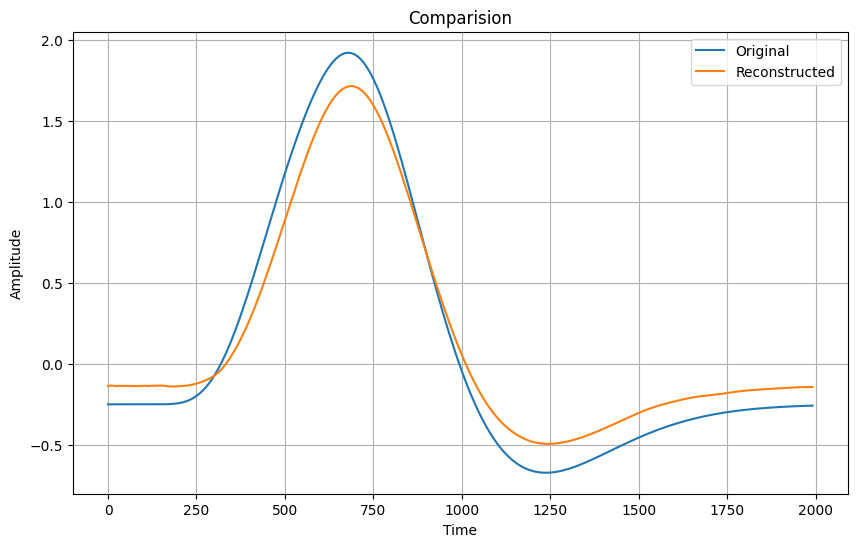

<Figure size 640x480 with 0 Axes>

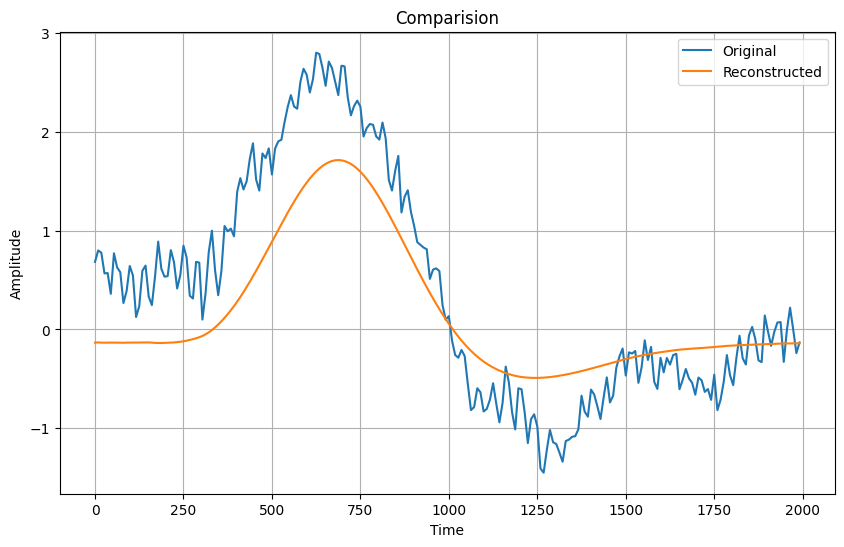

<Figure size 640x480 with 0 Axes>

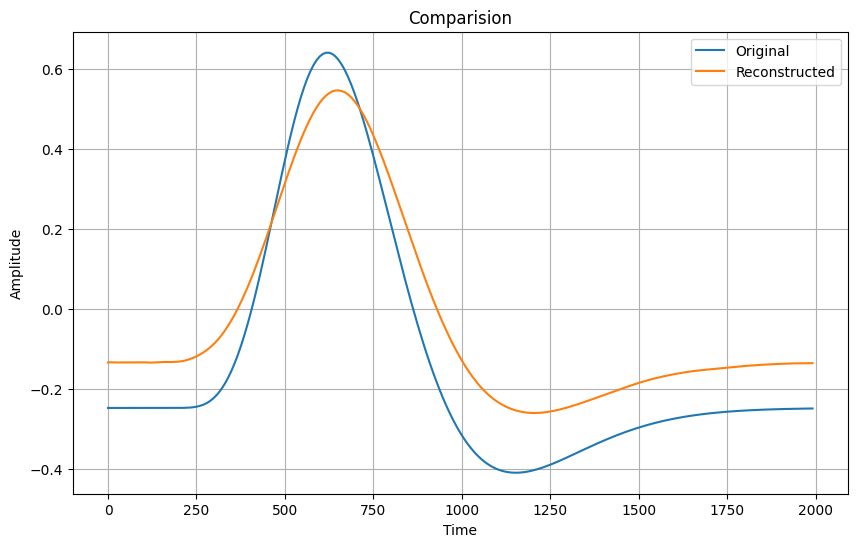

<Figure size 640x480 with 0 Axes>

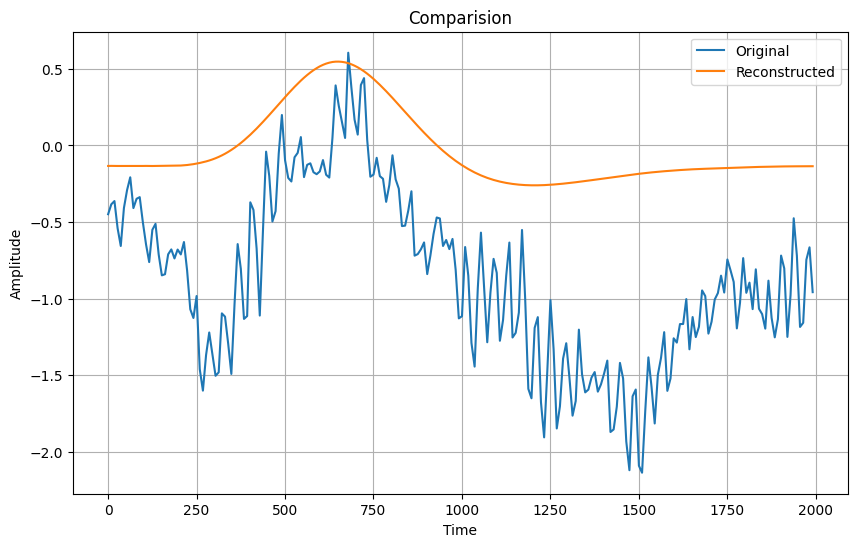

<Figure size 640x480 with 0 Axes>

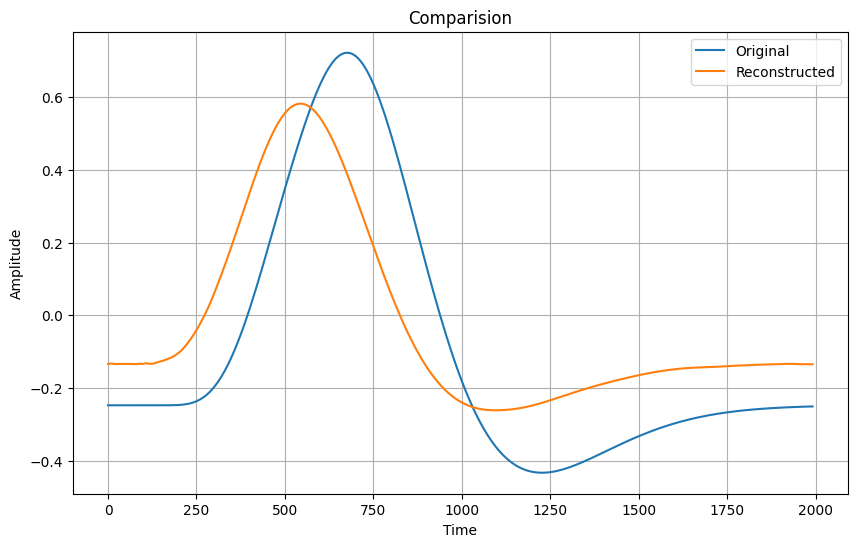

<Figure size 640x480 with 0 Axes>

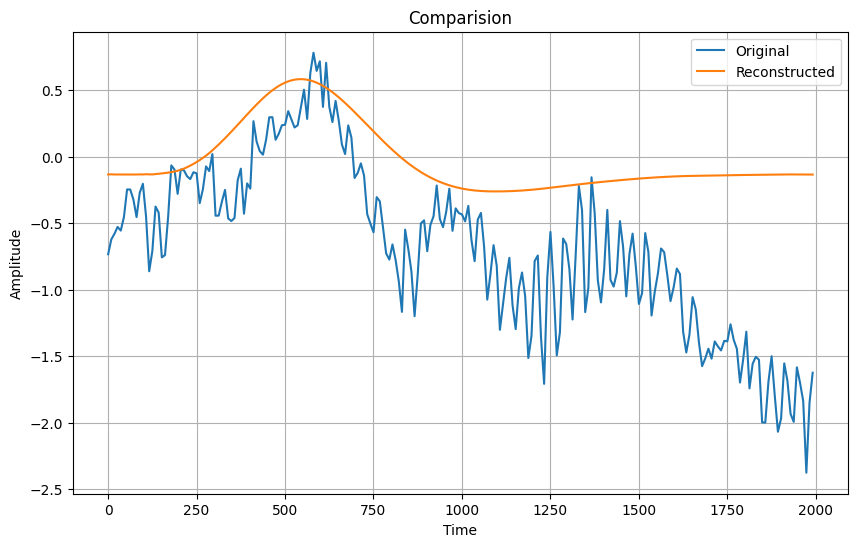

-------------------------------------- eeeeee -------------------------
Total loss of 93.30535312985276, with a mean loss of 1.8661070625970553 in a sample size of 1000


<Figure size 640x480 with 0 Axes>

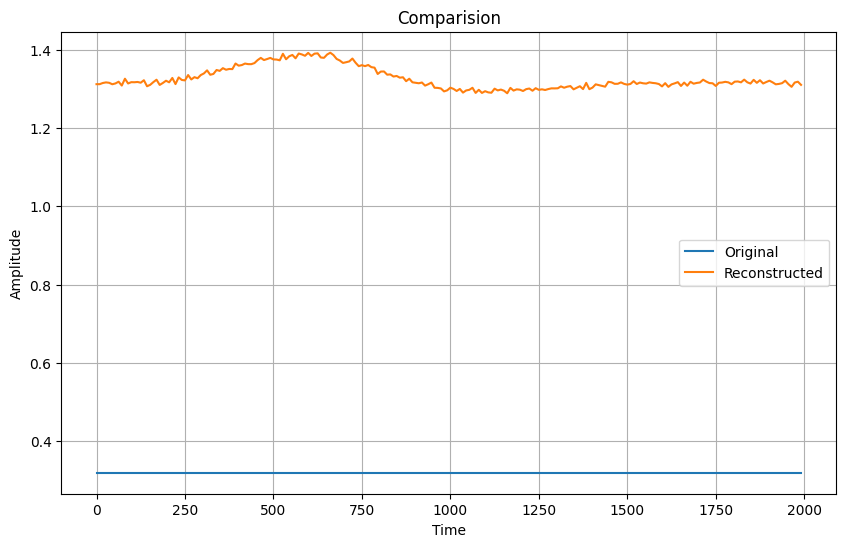

<Figure size 640x480 with 0 Axes>

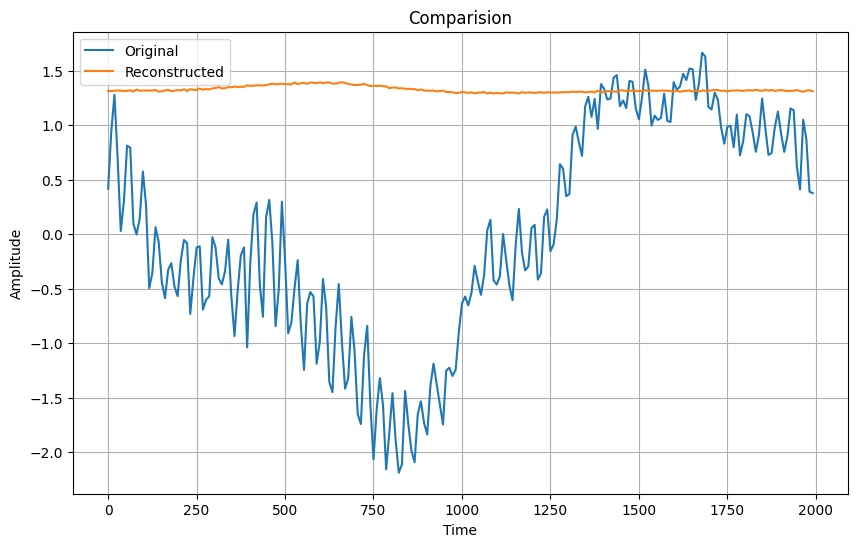

<Figure size 640x480 with 0 Axes>

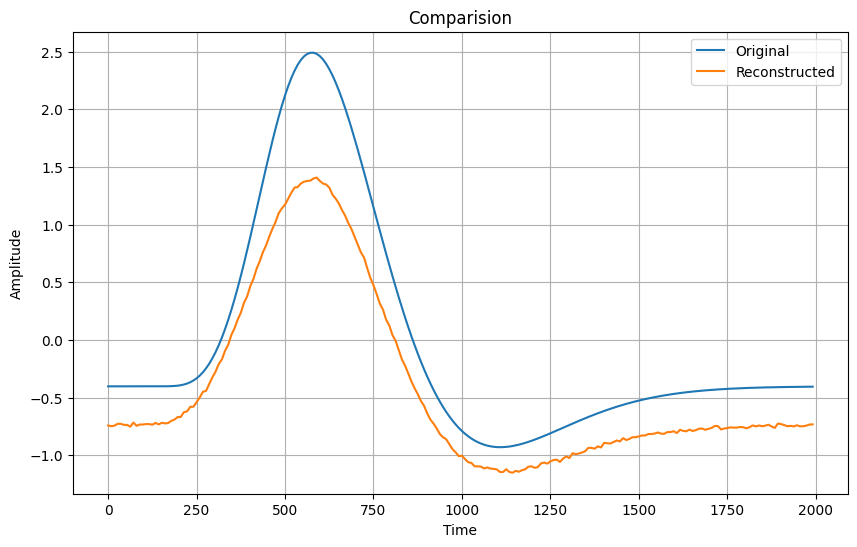

<Figure size 640x480 with 0 Axes>

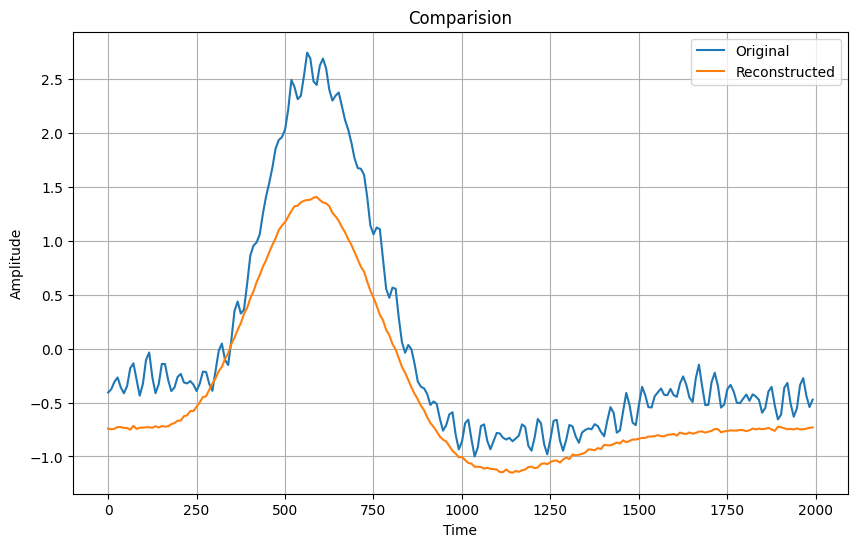

<Figure size 640x480 with 0 Axes>

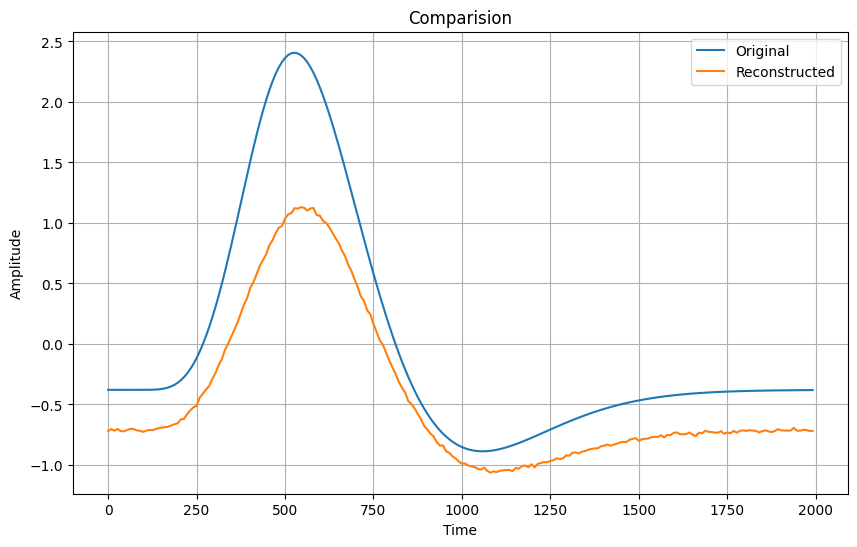

<Figure size 640x480 with 0 Axes>

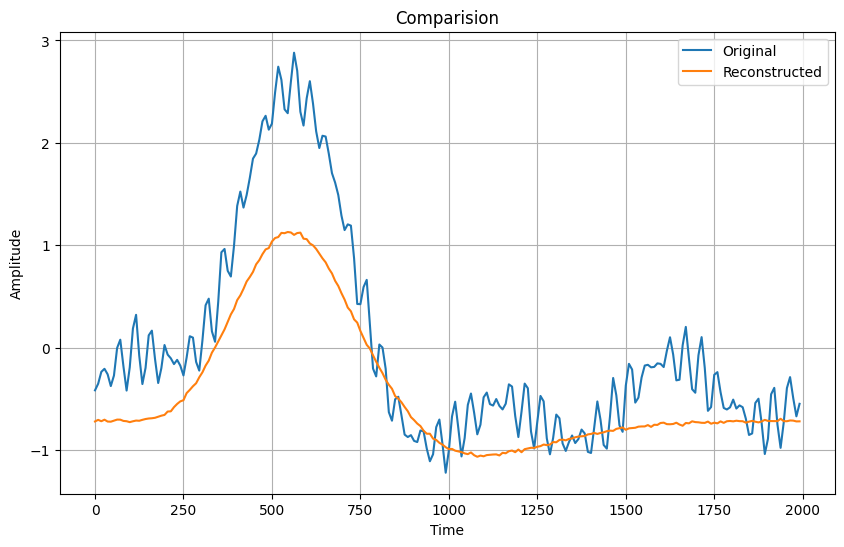

<Figure size 640x480 with 0 Axes>

In [543]:
# test_target, test_overlay = generator.generate_basic_test_data(100)
simple_test_set = simple_amplitude_database(np.array(test_target)[:, :224], np.array(test_overlay)[:, :224])

# test_target_wavelets, test_overlay_wavelets = [convs.wavedec(wave_signal) for wave_signal in test_target], [convs.wavedec(wave_signal) for wave_signal in (test_target + test_overlay)]
# test_padded_dataset = padded_wavelet_database(test_target_wavelets, test_overlay_wavelets, add_len = 5, inherit_params = None)
basic_eval_model(LSTM_model_v3, simple_test_set, evals.root_mean_square_error, display_num=3)
print("-------------------------------------- eeeeee -------------------------")
basic_eval_model(LSTM_model_v2, adapted_test_set, evals.root_mean_square_error, display_num=3)
# print("\n\n\n--------------------- END OF SIMPLE EVAL, START OF SPECTRO EVAL -----------------------\n\n\n")
# wavelet_eval_model(maxPooled_specto_model, padded_set, evals.root_mean_square_error, display_num=1)



Total loss of 80.92175470550309, with a mean loss of 0.16184350941100617 in a sample size of 10000


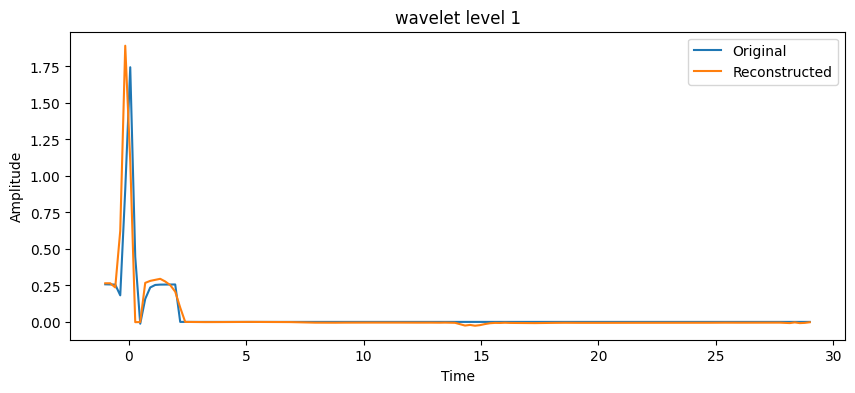

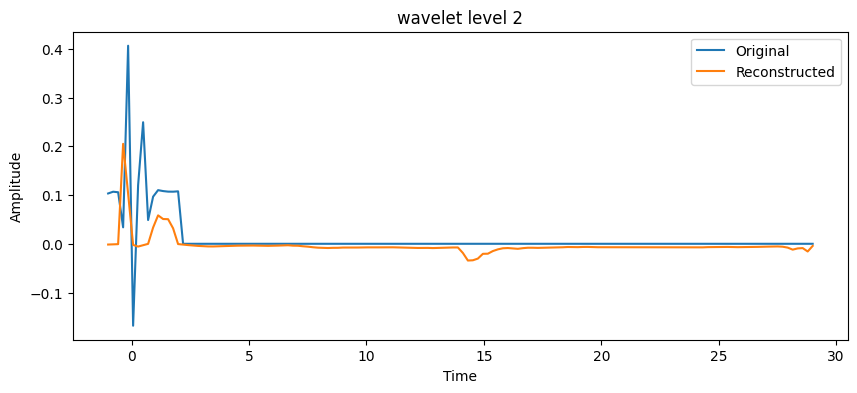

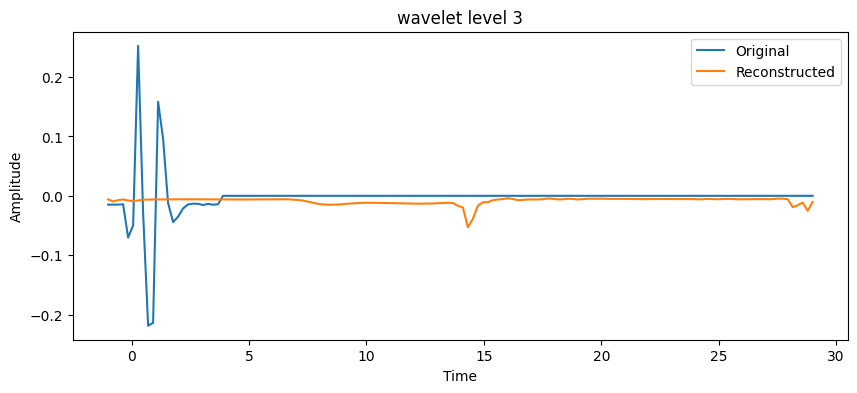

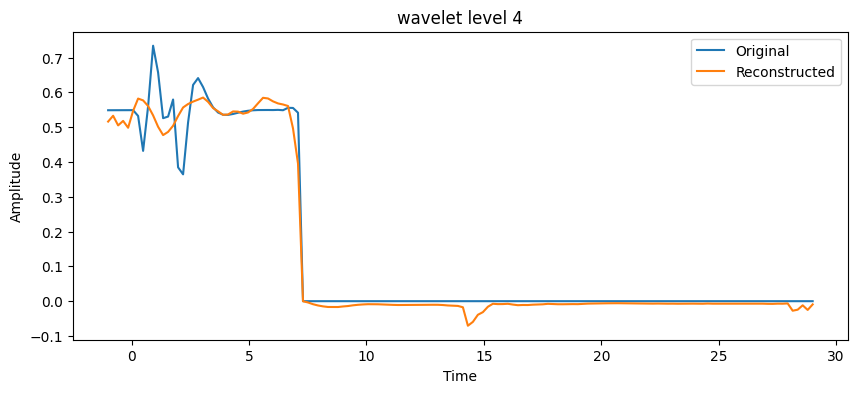

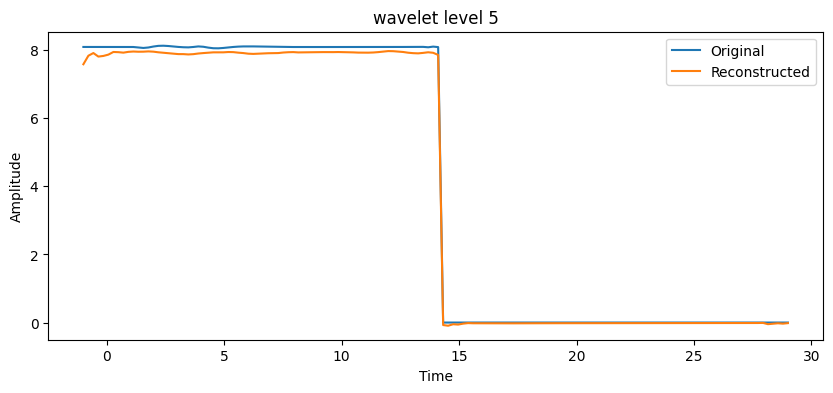

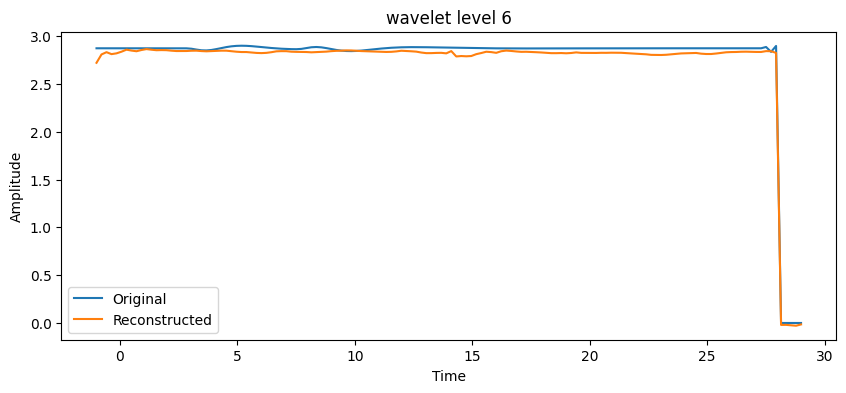

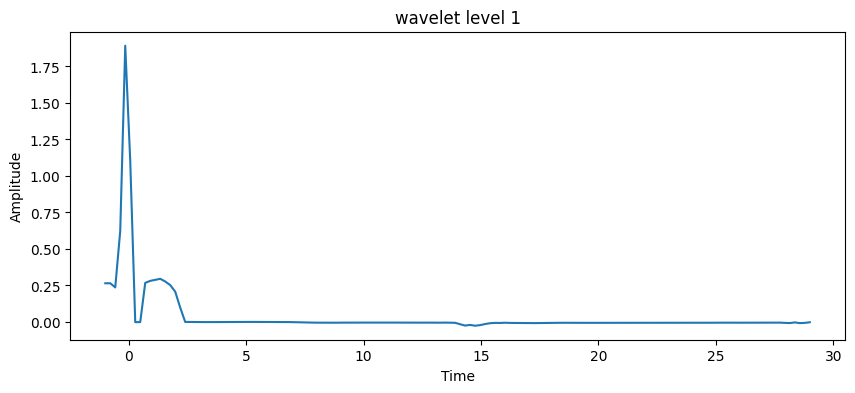

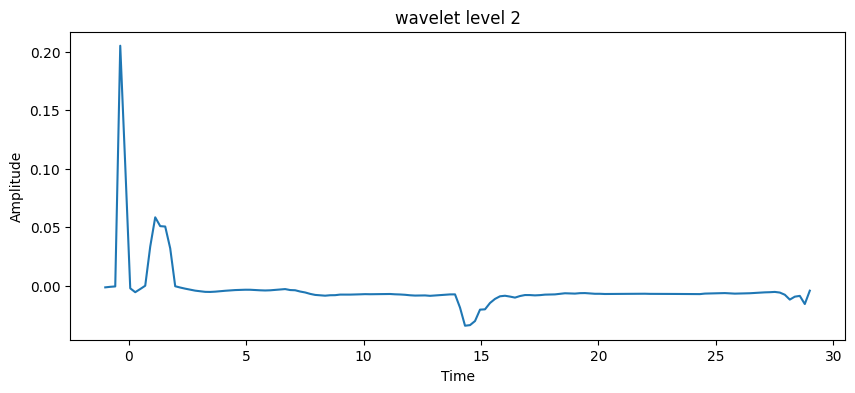

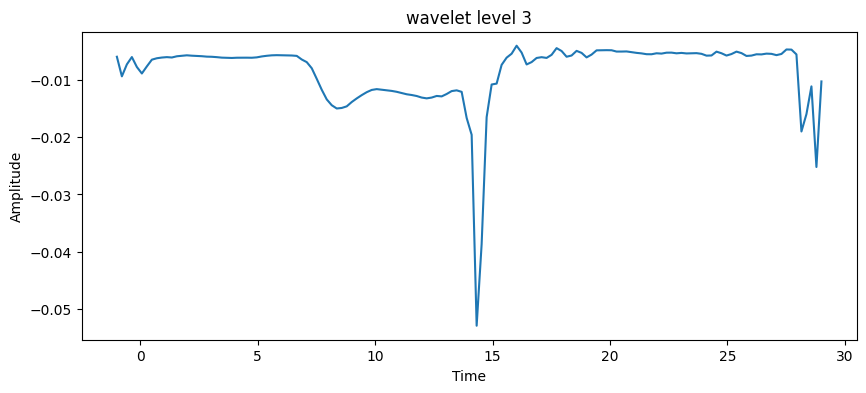

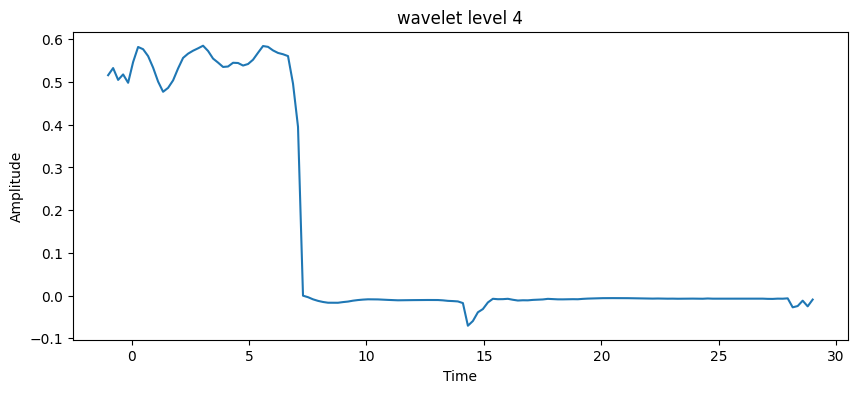

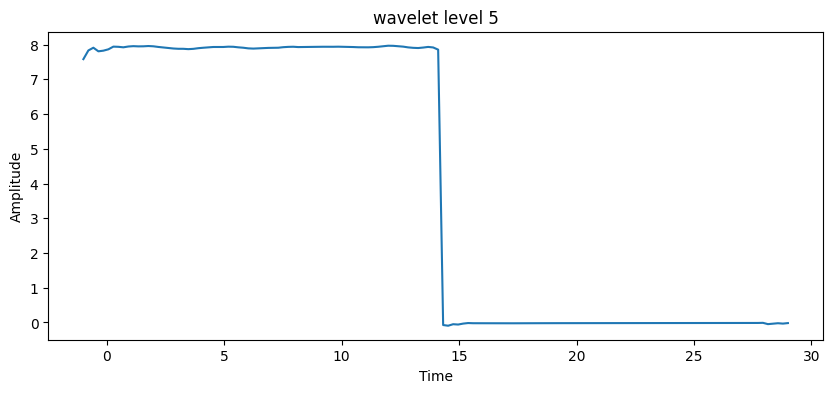

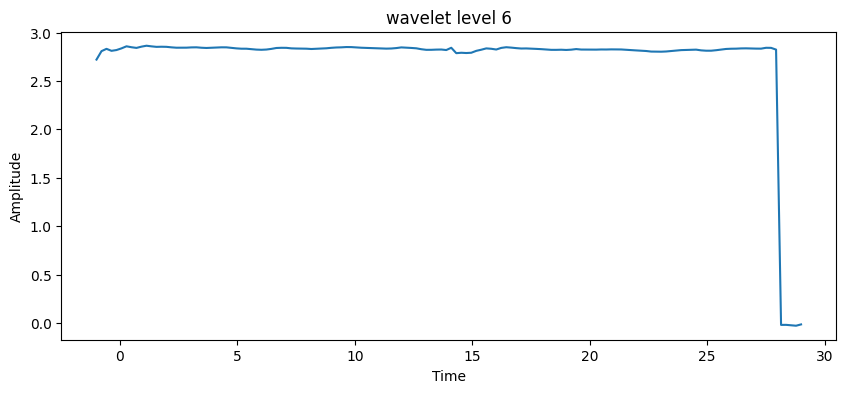

(1, 6, 142)
(1, 6, 142)
(1, 6, 142)


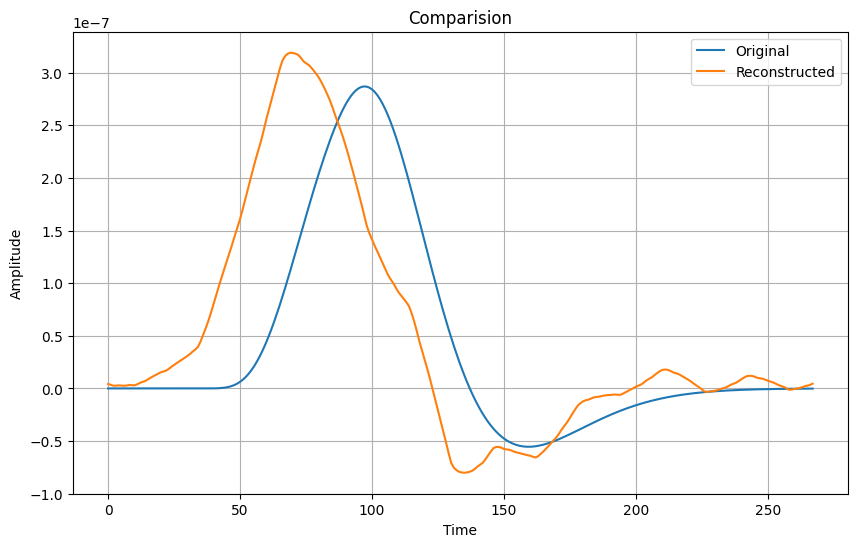

<Figure size 640x480 with 0 Axes>

In [309]:
# test_target_wavelets, test_overlay_wavelets = [convs.wavedec(wave_signal) for wave_signal in test_target], [convs.wavedec(wave_signal) for wave_signal in (test_target+ test_overlay)]
# test_padded_dataset = padded_wavelet_database(test_target_wavelets, test_overlay_wavelets, add_len = 5)

wavelet_eval_model(maxPooled_specto_model, padded_set, evals.root_mean_square_error, display_num=1)


In [ ]:
print(np.shape(padded_set.dirty[0]))
displays.plot_pChannel(padded_set.get_signal_back([padded_set.dirty[0]], padded_set.lengths), time_signal)

------------------------------simple model------------------------------
Total loss of 2.6813991912462547, with a mean loss of 0.05362798382492509 in a sample size of 1000


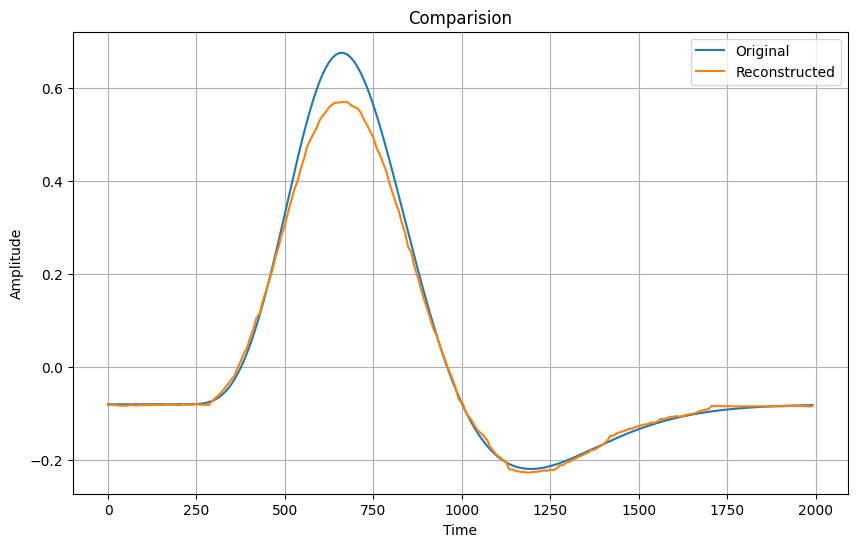

<Figure size 640x480 with 0 Axes>

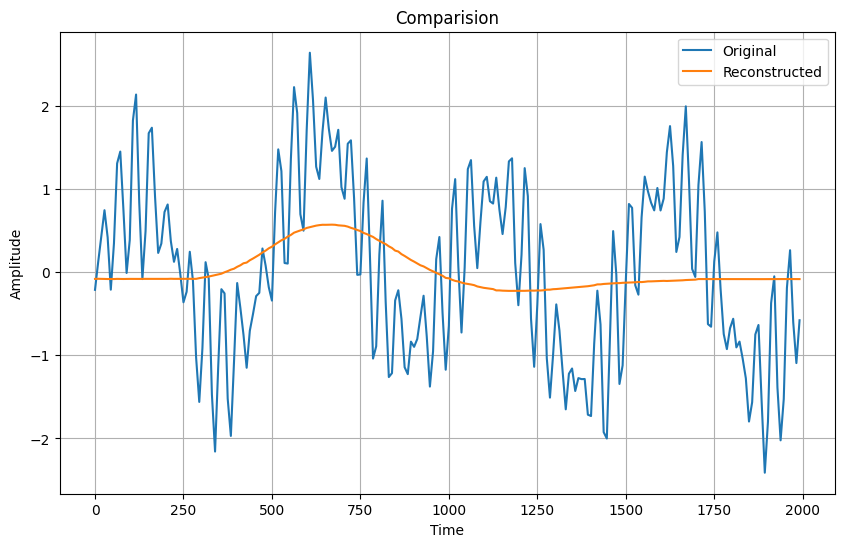

------------------------------LSTM model v_1------------------------------
Total loss of 0.5980980591347688, with a mean loss of 0.011961961182695375 in a sample size of 1000


<Figure size 640x480 with 0 Axes>

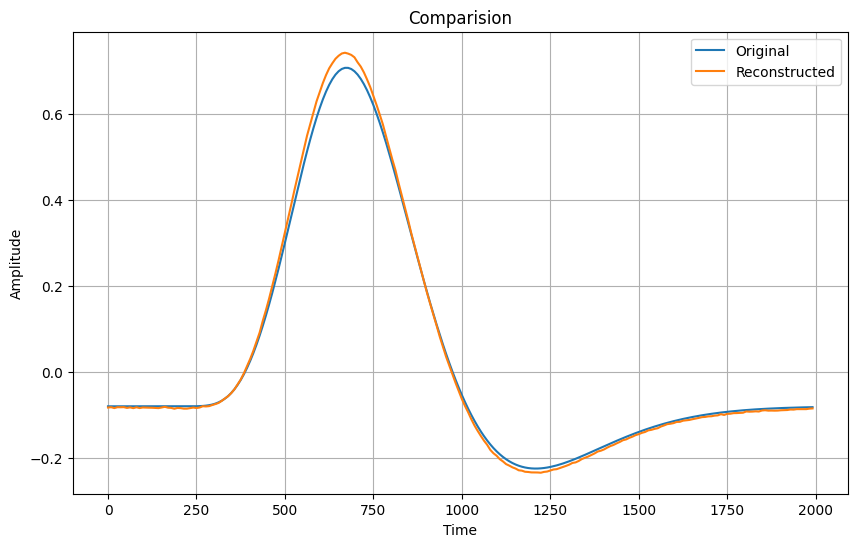

<Figure size 640x480 with 0 Axes>

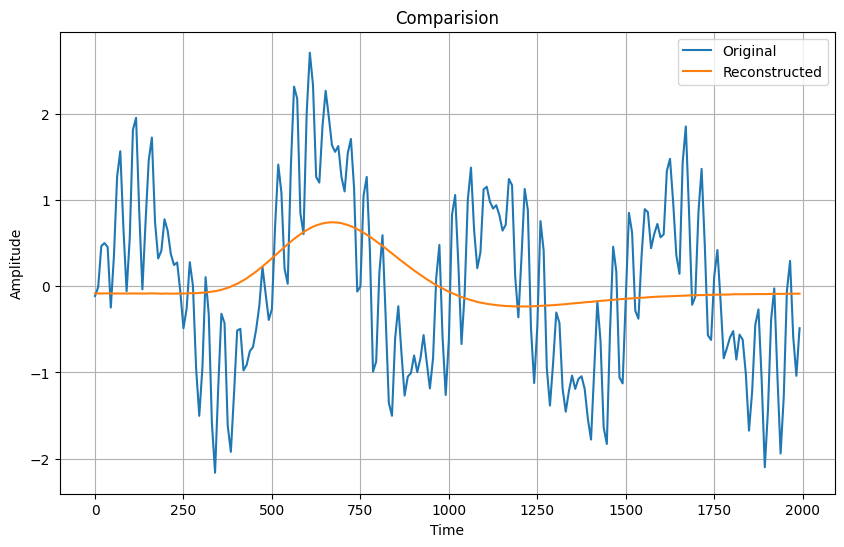

------------------------------LSTM model v_3------------------------------
Total loss of 0.8478280369002951, with a mean loss of 0.016956560738005902 in a sample size of 1000


<Figure size 640x480 with 0 Axes>

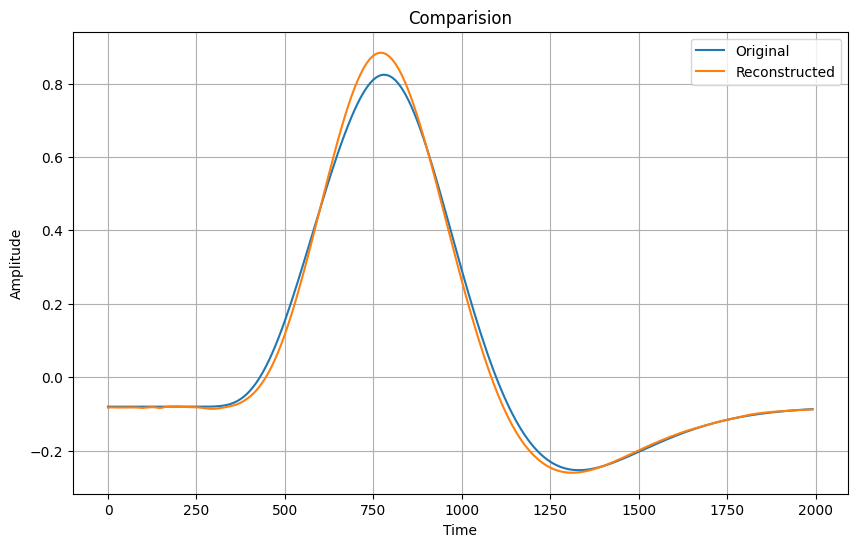

<Figure size 640x480 with 0 Axes>

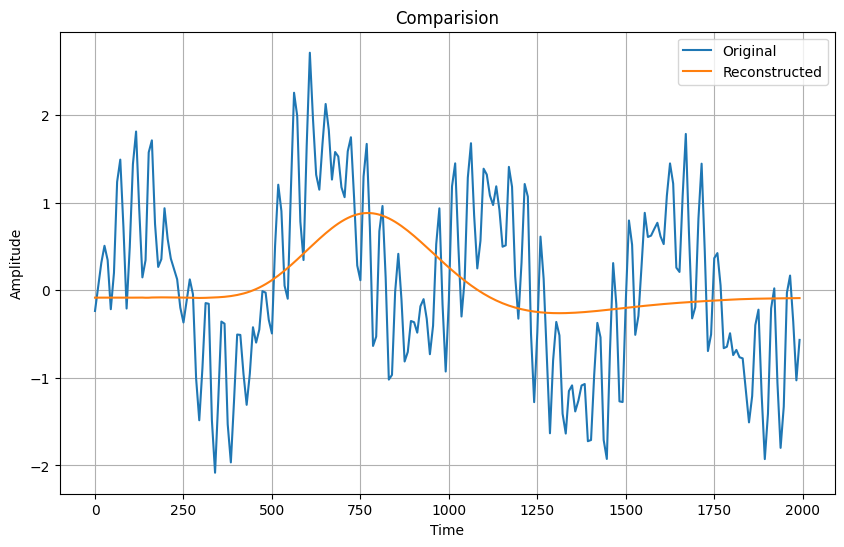

<Figure size 640x480 with 0 Axes>

In [368]:
print("------------------------------simple model------------------------------")
basic_eval_model(simp_model, simple_test_set, evals.root_mean_square_error, display_num=1)
print("------------------------------LSTM model v_1------------------------------")
basic_eval_model(LSTM_model_v2, simple_test_set, evals.root_mean_square_error, display_num=1)
print("------------------------------LSTM model v_3------------------------------")
basic_eval_model(LSTM_model_v3, simple_test_set, evals.root_mean_square_error, display_num=1)

In [ ]:
basic_eval_model(LSTM_model_v2, simple_test_set, evals.root_mean_square_error, display_num=1)

In [ ]:
len_Adder = 5
loader = DataLoader(test_padded_dataset, batch_size=1, shuffle=False)
maxs = 1
for (clean, dirty) in loader:
    if maxs > 0:
        displays.plot_pChannel(test_padded_dataset.get_signal_back(dirty.detach().numpy()[0], test_padded_dataset.lengths), range(len(test_padded_dataset.get_signal_back(dirty.detach().numpy()[0], test_padded_dataset.lengths))))
        reconser = maxPooled_specto_model(dirty)
        displays.plot_pChannel(test_padded_dataset.get_signal_back(reconser.detach().numpy()[0], test_padded_dataset.lengths), range(len(test_padded_dataset.get_signal_back(reconser.detach().numpy()[0], test_padded_dataset.lengths))))

        maxs -= 1
wavetester = padded_set.pad(test_wavelets, max(padded_set.lengths), add_len=len_Adder)[0]


#torch.tensor(padded_set.pad(test_wavelet[0], add_len=5), dtype=torch.float32)

# maxPooled_specto_model()